# Exploring Screen2vec
**01/03/2022 - ...**

**Roberto Araya Day**

Exploring RICO dataset with data analysis techniques and Screen2vec word embedding model.

In [1]:
import os
import argparse
import json
import numpy as np
import torch
from s2v_code.Screen2Vec import Screen2Vec
from sentence_transformers import SentenceTransformer
from s2v_code.prediction import TracePredictor
from s2v_code.autoencoder import ScreenLayout, LayoutAutoEncoder
from s2v_code.UI_embedding.UI2Vec import HiddenLabelPredictorModel, UI2Vec
from s2v_code.dataset.playstore_scraper import get_app_description
from s2v_code.dataset.rico_utils import get_all_labeled_uis_from_rico_screen, ScreenInfo
from s2v_code.dataset.rico_dao import load_rico_screen_dict

import pandas
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from datetime import datetime
from itertools import compress
import random

from google_play_scraper import app
import csv
import requests
import pandas as pd
from pathlib import Path
import umap.umap_ as umap

**Important Paths**

In [2]:
# path to important folders (may need to be changed)
screenvec = os.path.join(os.getcwd())
rico_dataset = os.path.join(os.path.dirname(os.getcwd()), \
"RICO_CLAY_data", "unique_uis.tar", "unique_uis", "combined")
rico_layout_dataset = os.path.join(os.path.dirname(os.getcwd()), \
"RICO_CLAY_data", "sem_annot", "semantic_annotations")

pretrained_model = os.path.join(screenvec, "s2v_pre-trained_model")
saved_tensors = os.path.join(os.getcwd(), "rico_tensors")
saved_popular_tensors = os.path.join(os.getcwd(), "popular_rico_tensors")

# path of the apps metadata
ui_details_csv = os.path.join(os.path.dirname(os.getcwd()), \
"RICO_CLAY_data", "ui_details.csv")
app_details_csv = os.path.join(os.path.dirname(os.getcwd()), \
"RICO_CLAY_data", "app_details.csv")

ui_names_csv = os.path.join(os.path.dirname(os.getcwd()), \
"RICO_CLAY_data", "ui_layout_vectors", "ui_layout_vectors", "ui_names.json")
layout_embedding_csv = os.path.join(os.path.dirname(os.getcwd()), \
"RICO_CLAY_data", "ui_layout_vectors", "ui_layout_vectors", "ui_vectors.npy")

# path of pre-trained model
gui_element_path = os.path.join(pretrained_model, "UI2Vec_model.ep120")
screen2vec_path = os.path.join(pretrained_model,"Screen2Vec_model_v4.ep120")
layout_encoder = os.path.join(pretrained_model,"layout_encoder.ep800")

# path of the saved plots and figures
saved_plt_path = os.path.join(os.getcwd(), "results")
cluster_examples = os.path.join(saved_plt_path, "cluster_examples")

# path for saving the results
records = "records.txt"
records_path = os.path.join(saved_plt_path, records)

**Gets the vector embeddings for an input screen using the Screen2Vec model.**

In [3]:
# Generates the vector embeddings for an input screen
# net version decides 
def get_embedding_project(screen, ui_model, screen_model, layout_model, num_predictors, net_version):

    # uses the screen and obtains the data if similar to rico image?
    with open(screen) as f:
        rico_screen = load_rico_screen_dict(json.load(f))
    labeled_text = get_all_labeled_uis_from_rico_screen(rico_screen)

    bert = SentenceTransformer('bert-base-nli-mean-tokens')
    bert_size = 768

    ### 1. GUI COMPONENT EMBEDDER
    ## 1. UI MODEL - GUI element embedding model.
    # initializes the model
    loaded_ui_model = HiddenLabelPredictorModel(bert, bert_size, 16)
    loaded_ui_model.load_state_dict(torch.load(ui_model), strict=False)

    # obtains class and text of components from the layout of screenshot, and creates variable [text, class]
    ui_class = torch.tensor([UI[1] for UI in labeled_text])
    ui_text = [UI[0] for UI in labeled_text]

    # obtains ambedding for all components in the UI
    UI_embeddings = loaded_ui_model.model([ui_text, ui_class])
    #print("UI embeddings shape: ", UI_embeddings.shape)

    #avg_embedding = UI_embeddings.sum(dim=0)/len(labeled_text)

    ### 2.1 SCREEN HERARCHY - APP DESCRIPTION
    # gets description from app's google play metadata, if not, it leaves blank
    try:
        package_name = rico_screen.activity_name.split("/")[0]
        descr = get_app_description(package_name)
    except Exception as e:
        descr = ''

    # encodes description using BERT model - APP DESCRIPTION IN IMAGE
    descr_emb = torch.as_tensor(bert.encode([descr]), dtype=torch.float)
    
    ### 2.2 LAYOUT AUTOENCODER
    ## 3. LAYOUT MODEL
    # initializes and loads layout autoencoder, and encoding
    layout_autoencoder = LayoutAutoEncoder()
    layout_autoencoder.load_state_dict(torch.load(layout_model))
    layout_embedder = layout_autoencoder.enc

    # gets pixels from screen and encoded layout from screen sample
    screen_to_add = ScreenLayout(screen)
    screen_pixels = screen_to_add.pixels.flatten()
    encoded_layout = layout_embedder(torch.as_tensor(screen_pixels, dtype=torch.float).unsqueeze(0)).squeeze(0)


    if net_version in [0,2,6]:
        adus = 0
    else:
        # case where coordinates are part of UI rnn
        adus = 4
    if net_version in [0,1,6]:
        adss = 0
    else:
        # case where screen layout vec is used
        adss = 64
    if net_version in [0,1,2,3]:
        desc_size = 768
    else:
        # no description in training case
        desc_size = 0

    ### 2.3 
    # initializes and loads screen embedder from parameter
    # 2... SCREEN MODEL
    screen_embedder = Screen2Vec(bert_size, adus, adss, net_version)
    loaded_screen_model = TracePredictor(screen_embedder, net_version)
    loaded_screen_model.load_state_dict(torch.load(screen_model))


    if net_version in [1,3,4,5]:
        coords = torch.FloatTensor([labeled_text[x][2] for x in range(len(UI_embeddings))])
        UI_embeddings = torch.cat((UI_embeddings.cpu(),coords),dim=1)
    if net_version in [0,1,6]:
        screen_layout = None
    else: screen_layout = encoded_layout.unsqueeze(0).unsqueeze(0)
    
    #print("UI_embeddings shape: ", UI_embeddings.unsqueeze(1).unsqueeze(0).shape)
    #print("Description embedding: ", descr_emb.shape)
    #print("Screen layout shape: ", screen_layout.shape)
    # computes de Screen2Vec embedding using the GUI component embeddings, description embedding, and layout encoder.
    screen_emb = screen_embedder(UI_embeddings.unsqueeze(1).unsqueeze(0), descr_emb.unsqueeze(0), None, screen_layout, False)

    if descr_emb.size()[0] == 1:
        descr_emb = descr_emb.squeeze(0)
    #baseline_emb = torch.cat((avg_embedding, descr_emb), dim=0)
    
    #print(encoded_layout.size())
    #print(screen_emb.size())
    #print((screen_emb[0][0]).size())
    #print()
    return screen_emb[0][0]
    #return screen_emb[0][0]
    
    

# Generates the vector embeddings for an input screen
# net version decides 
def get_embedding_layout_project(screen, ui_model, screen_model, layout_model, num_predictors, net_version):

    # uses the screen and obtains the data if similar to rico image?
    with open(screen) as f:
        rico_screen = load_rico_screen_dict(json.load(f))
    labeled_text = get_all_labeled_uis_from_rico_screen(rico_screen)

    bert = SentenceTransformer('bert-base-nli-mean-tokens')
    bert_size = 768

    ### 1. GUI COMPONENT EMBEDDER
    ## 1. UI MODEL - GUI element embedding model.
    # initializes the model
    loaded_ui_model = HiddenLabelPredictorModel(bert, bert_size, 16)
    loaded_ui_model.load_state_dict(torch.load(ui_model), strict=False)

    # obtains class and text of components from the layout of screenshot, and creates variable [text, class]
    ui_class = torch.tensor([UI[1] for UI in labeled_text])
    ui_text = [UI[0] for UI in labeled_text]

    # obtains ambedding for all components in the UI
    UI_embeddings = loaded_ui_model.model([ui_text, ui_class])
    #print("UI embeddings shape: ", UI_embeddings.shape)

    #avg_embedding = UI_embeddings.sum(dim=0)/len(labeled_text)

    ### 2.1 SCREEN HERARCHY - APP DESCRIPTION
    # gets description from app's google play metadata, if not, it leaves blank
    try:
        package_name = rico_screen.activity_name.split("/")[0]
        descr = get_app_description(package_name)
    except Exception as e:
        descr = ''

    # encodes description using BERT model - APP DESCRIPTION IN IMAGE
    descr_emb = torch.as_tensor(bert.encode([descr]), dtype=torch.float)
    
    ### 2.2 LAYOUT AUTOENCODER
    ## 3. LAYOUT MODEL
    # initializes and loads layout autoencoder, and encoding
    layout_autoencoder = LayoutAutoEncoder()
    layout_autoencoder.load_state_dict(torch.load(layout_model))
    layout_embedder = layout_autoencoder.enc

    # gets pixels from screen and encoded layout from screen sample
    screen_to_add = ScreenLayout(screen)
    screen_pixels = screen_to_add.pixels.flatten()
    encoded_layout = layout_embedder(torch.as_tensor(screen_pixels, dtype=torch.float).unsqueeze(0)).squeeze(0)


    if net_version in [0,2,6]:
        adus = 0
    else:
        # case where coordinates are part of UI rnn
        adus = 4
    if net_version in [0,1,6]:
        adss = 0
    else:
        # case where screen layout vec is used
        adss = 64
    if net_version in [0,1,2,3]:
        desc_size = 768
    else:
        # no description in training case
        desc_size = 0

    ### 2.3 
    # initializes and loads screen embedder from parameter
    # 2... SCREEN MODEL
    screen_embedder = Screen2Vec(bert_size, adus, adss, net_version)
    loaded_screen_model = TracePredictor(screen_embedder, net_version)
    loaded_screen_model.load_state_dict(torch.load(screen_model))


    if net_version in [1,3,4,5]:
        coords = torch.FloatTensor([labeled_text[x][2] for x in range(len(UI_embeddings))])
        UI_embeddings = torch.cat((UI_embeddings.cpu(),coords),dim=1)
    if net_version in [0,1,6]:
        screen_layout = None
    else: screen_layout = encoded_layout.unsqueeze(0).unsqueeze(0)
    
    #print("UI_embeddings shape: ", UI_embeddings.unsqueeze(1).unsqueeze(0).shape)
    #print("Description embedding: ", descr_emb.shape)
    #print("Screen layout shape: ", screen_layout.shape)
    # computes de Screen2Vec embedding using the GUI component embeddings, description embedding, and layout encoder.
    screen_emb = screen_embedder(UI_embeddings.unsqueeze(1).unsqueeze(0), descr_emb.unsqueeze(0), None, screen_layout, False)

    if descr_emb.size()[0] == 1:
        descr_emb = descr_emb.squeeze(0)
    #baseline_emb = torch.cat((avg_embedding, descr_emb), dim=0)
    
    #print(encoded_layout.size())
    #print(screen_emb.size())
    #print((screen_emb[0][0]).size())
    #print()
    return screen_layout
    #return screen_emb[0][0]



**Computes and gets the embedding vectors of the screenshot layouts and saves them**

In [4]:
def save_embeddings(a: int, b: int) -> None:
    """Computes the embedding vectors of the screenshot layouts named from a to b, 
       and saves them as ".pt" files at 'saved_tensors' folder."""
    
    for i in range(a, b):
        print(i)
        try:
        # gets and computes the layout embedding vector
            layout = os.path.join(rico_dataset, f"{i}.json")
            embedding = get_embedding_project(layout, gui_element_path, screen2vec_path, layout_encoder, 4, 4)

            # saves the tensor at "save_tensor"
            save_tensor = os.path.join(saved_tensors, f"{i}.pt")
            torch.save(embedding, save_tensor)
        
        except FileNotFoundError:
            pass
        except RuntimeError:
            pass

def save_embeddings_array(array: [int], pre: int) -> [int]:
    """Computes the embedding vectors of the screenshot layouts named from a to b, 
       and saves them as ".pt" files at 'saved_tensors' folder."""
    
    not_found = []
    name = "popular_folder_"+str(pre)
    popular_folder = os.path.join(os.getcwd(), name)
    
    print(popular_folder)
    Path(popular_folder).mkdir(parents=True, exist_ok=True)
    for i in array:
        print(i)
        try:
        # gets and computes the layout embedding vector
            layout = os.path.join(rico_dataset, f"{i}.json")
            embedding = get_embedding_project(layout, gui_element_path, screen2vec_path, layout_encoder, 4, 4)

            # saves the tensor at "save_tensor"
            save_tensor = os.path.join(popular_folder, f"{i}.pt")
            torch.save(embedding, save_tensor)
        
        except FileNotFoundError:
            not_found.append(i)
        except RuntimeError:
            not_found.append(i)
    return not_found


def save_layout_embeddings_array(array: [int], pre: int) -> [int]:
    """Computes the embedding vectors of the screenshot layouts named from a to b, 
       and saves them as ".pt" files at 'saved_tensors' folder."""
    
    not_found = []
    name = "popular_layouts_folder_"+str(pre)
    popular_folder = os.path.join(os.getcwd(), name)
    
    print(popular_folder)
    Path(popular_folder).mkdir(parents=True, exist_ok=True)
    for i in array:
        print(i)
        try:
        # gets and computes the layout embedding vector
            layout = os.path.join(rico_dataset, f"{i}.json")
            embedding = get_embedding_layout_project(layout, gui_element_path, screen2vec_path, layout_encoder, 4, 4)

            # saves the tensor at "save_tensor"
            save_tensor = os.path.join(popular_folder, f"{i}.pt")
            torch.save(embedding, save_tensor)
        
        except FileNotFoundError:
            not_found.append(i)
        except RuntimeError:
            not_found.append(i)
    return not_found

def get_embeddings(a: int, b: int) -> ([torch.Tensor], [int]):
    """Gets the embedding vectors of the app's screenshots "a".jpg to "b".jpg
       saved in the files "a".pt to "b".pt."""
    
    embeddings = []
    not_found = []
    
    # loads the tensors at "saved_tensors" from a to b
    for i in range(a, b):
        try:
            iembed = os.path.join(saved_tensors, f"{i}.pt")
            embeddings.append(torch.load(iembed))
        except FileNotFoundError:
            #print(i)
            not_found.append(i)
    return (embeddings, not_found)


def get_popular_embeddings(pop_path) -> ([int], [torch.Tensor]):
    """Gets the embedding vectors of the popular app's screenshots saved in the popular """
    
    found = []
    embeddings = []
    
    # loads the tensors at "saved_tensors" from a to b
    for i in range(0, 70000):
        try:
            iembed = os.path.join(pop_path, f"{i}.pt")
            embeddings.append(torch.load(iembed))
            found.append(i)
        except FileNotFoundError:
            #print(i)
            pass
    return (embeddings, found)



**Gets k random examples from the i cluster**

In [5]:
def get_random_examples(labels, j, k, not_found):
    """Gets k random screenshots that belongs to the 'i' cluster."""

    #indexes = list(map(int, labels==True))
    indexes = [i for i, x in enumerate(list(labels)) if x==j]
    for i in not_found:
        try: indexes.remove(i)
        except ValueError: pass
    a = random.choices(indexes, k=k)
    return a

def get_random_popular_examples(labels, j, k, found, opt=None):
    """Gets k random screenshots that belongs to the 'i' cluster from the "popular" examples."""
    
    indexes = [i for i, x in enumerate(list(labels)) if x==j]
    res_list = [found[i] for i in indexes]
    a = random.choices(res_list, k=k)
    return a

**Computes SSE vs number of clusters using KMeans from 1 to n and find the elbow point**

In [6]:
def compute_kmeans_sse(embeddings: np.ndarray, n:int) -> list[int]:
    '''Computes SSE (sum squared error) vs number of clusters using KMeans from 1 to n and find
    the "elbow point", the point after which the SSE or inertia starts decreasing in linear fashion'''
    
    clusters = list(range(1, n))
    sse = []
    for k in clusters:
        kmeans = KMeans(n_clusters = k).fit(embeddings)
        sse.append(kmeans.inertia_)
    print(clusters)
    print(sse)
    plt.xlim(0, 30)
    plt.plot(clusters, sse, marker="o")
    plt.title("K-Means SSE")
    plt.xlim(0, n)
    plt.grid(True)
    plt.savefig(os.path.join(saved_plt_path, "SSE_n°_of_clusters"))
    plt.show()
    return sse

## 1. Data analysis of the RICO dataset using clustering methods

In [52]:
# datetime object containing current date and time
now = datetime.now()

# opens the file of the records file
record_res = open(records_path, 'a')
record_res.write("Records :"+ now.strftime("%H:%M %Y/%m/%d")+"\n")
#save_embeddings(2000, 3000)
#616

# gets the embedding vectors from the a to b screenshot
a,b = 0,15060
embeddings, not_found = get_embeddings(a,b)

embeddings = torch.stack(embeddings, dim=0)
record_res.write(f"Results from RICO screenshots {a}-{b}: {b-a}"+ "\n")

# gets numpy embeddings from the embeddings
numpy_embeddings = embeddings.detach().numpy()

record_res.write("\n\n")
record_res.close()

**Applying PCA dimensionality reduction**

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[638180.1875, 170660.78125, 46877.43359375, 29833.220703125, 22135.439453125, 16376.1474609375, 12346.0048828125, 10387.10546875, 8872.4794921875, 7846.89501953125, 7034.61083984375, 6328.42431640625, 5737.3447265625, 5231.80908203125, 4766.0234375, 4374.4345703125, 4127.06494140625, 3828.58447265625, 3605.73388671875, 3395.352294921875, 3208.398193359375, 3078.8466796875, 2919.47802734375, 2790.505615234375, 2700.369140625, 2576.427978515625, 2475.12255859375, 2396.800048828125, 2320.531982421875]


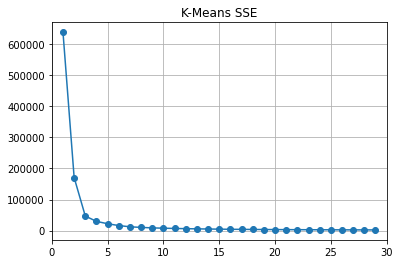

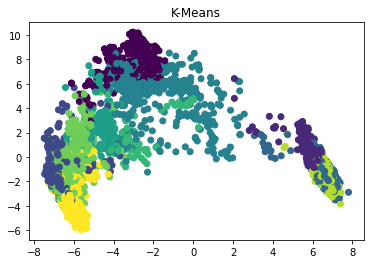

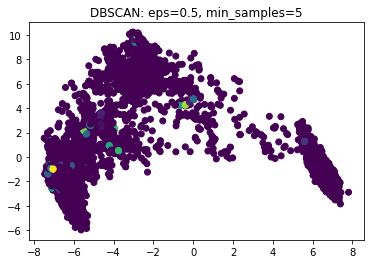

Estimated number of clusters: 80
Estimated number of noise points: 12294


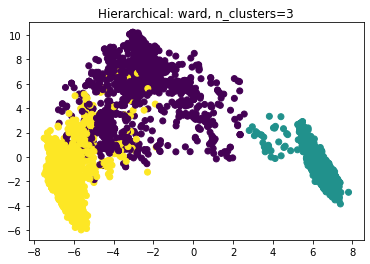

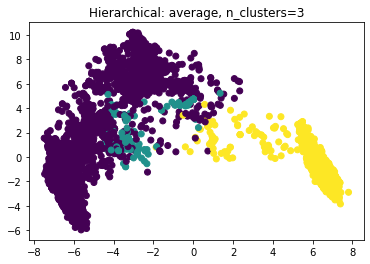

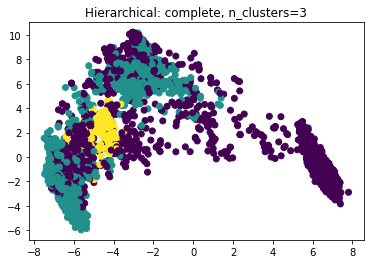

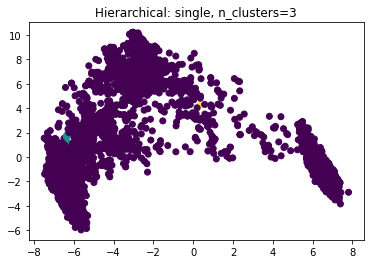

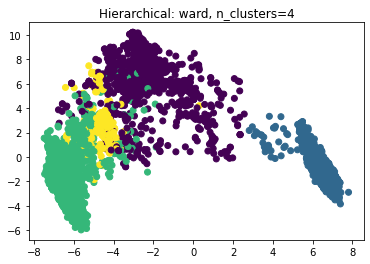

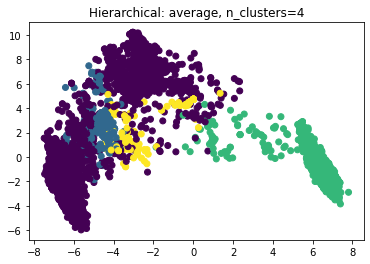

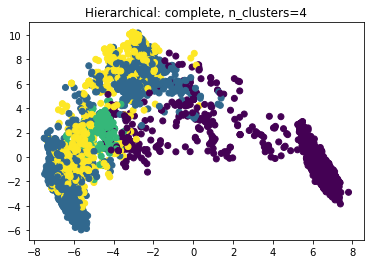

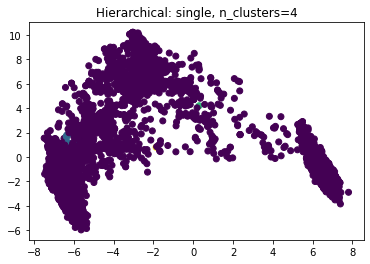

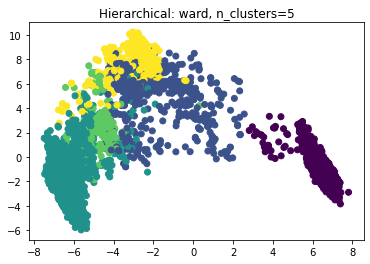

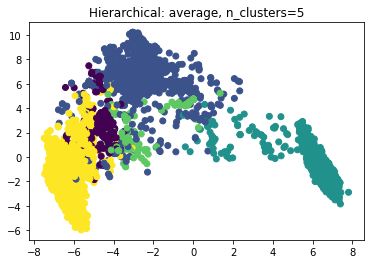

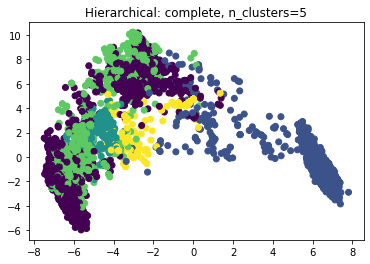

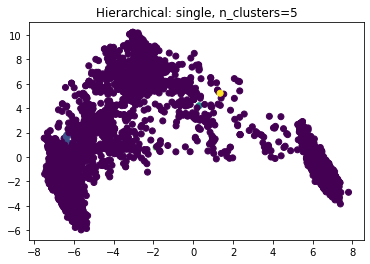

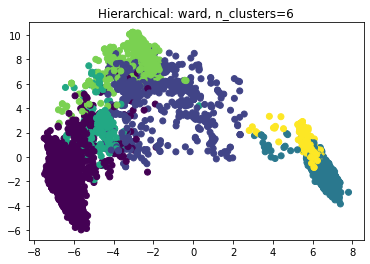

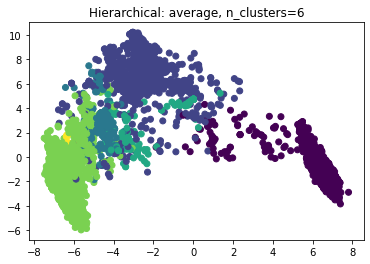

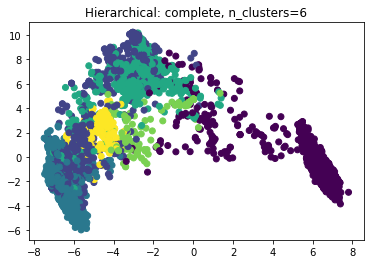

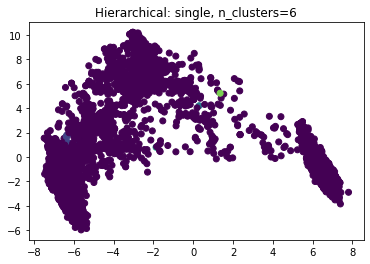

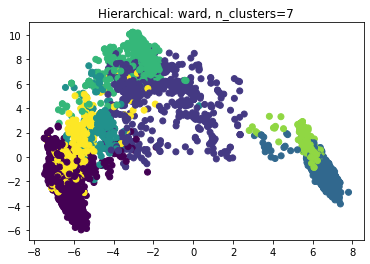

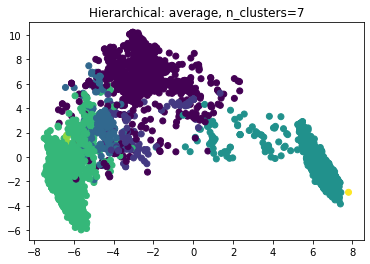

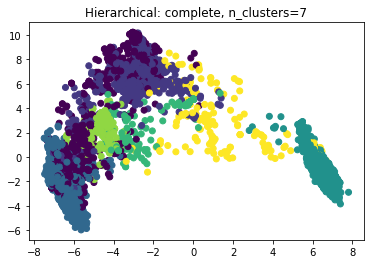

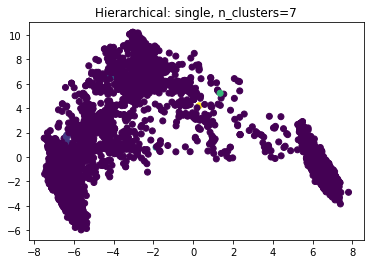

Finishing Program


In [53]:
# apply PCA to reduce the dimensionality of the embeddings
reduced_embeddings = PCA(n_components = 2, random_state=2).fit_transform(numpy_embeddings)

# compute SSE (sum squared error) vs number of clusters and find the "elbow point", the point after
# which the SSE or inertia starts decreasing in linear fashion
sse = compute_kmeans_sse(reduced_embeddings, 30)

# apply k means
kmeans_n_clusters = 10
kmeans = KMeans(n_clusters = kmeans_n_clusters, n_init = 20, random_state = 10)
kmeans.fit(numpy_embeddings)

plt.scatter(reduced_embeddings[:,0], reduced_embeddings[:,1], c=kmeans.labels_)
plt.title("K-Means")
plt.savefig(os.path.join(saved_plt_path, "Kmeans"))
plt.show()

eps = 0.5
min_samples = 5

# DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(numpy_embeddings)
plt.scatter(reduced_embeddings[:,0], reduced_embeddings[:,1], c=dbscan.labels_)
plt.title(f"DBSCAN: eps={eps}, min_samples={min_samples}")
plt.savefig(os.path.join(saved_plt_path, "DBSCAN"))
plt.show()

dbscan_2 = DBSCAN(eps=eps, min_samples=min_samples).fit(numpy_embeddings)
labels = dbscan_2.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)


#record_res.write("DBSCAN\n")
str_clusters = "Estimated number of clusters: %d" % n_clusters_
str_noise = "Estimated number of noise points: %d" % n_noise_

#record_res.write(str_clusters + "\n")
#record_res.write(str_noise + "\n")

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Agglomerative Clustering
# for clusters from 3 to 8, and the 4 linkage criteria
n_clusters = range(3,8)
linkage = ["ward", "average", "complete", "single"]


save_labels = []
for k in n_clusters:
    for criteria in linkage:
        clust = AgglomerativeClustering(n_clusters=k, linkage=criteria).fit(numpy_embeddings)
        plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clust.labels_)
        plt.title(f"Hierarchical: {criteria}, n_clusters={k}")
        plt.savefig(os.path.join(saved_plt_path, f"AgglomerativeClustering~{k}~{criteria}"))
        plt.show()

print("Finishing Program")

**Apply UMAP dimensionality reduction**

In [ ]:
import umap.umap_ as umap

reducer = umap.UMAP(random_state=4)
umap_embeddings = reducer.fit_transform(numpy_embeddings)

plt.scatter(
    umap_embeddings[:, 0],
    umap_embeddings[:, 1],
    #c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
)
plt.gca().set_aspect('equal', 'datalim')
plt.savefig(os.path.join(saved_plt_path, "UMAP_reduction"))
plt.title('UMAP Dimension reduction algorithm', fontsize=24)

# apply k means
kmeans_n_clusters = 4
kmeans = KMeans(n_clusters = kmeans_n_clusters, n_init = 20, random_state = 10)
kmeans.fit(numpy_embeddings)

plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1], c=kmeans.labels_)
plt.title("UMAP K-Means")
plt.savefig(os.path.join(saved_plt_path, "UMAP Kmeans"))
plt.show()

eps = 0.5
min_samples = 5

# DBSCAN
umap_dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(numpy_embeddings)
plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1], c=umap_dbscan.labels_)
plt.title(f"UMAP DBSCAN: eps={eps}, min_samples={min_samples}")
plt.savefig(os.path.join(saved_plt_path, "umap_DBSCAN"))
plt.show()

umap_dbscan_2 = DBSCAN(eps=eps, min_samples=min_samples).fit(numpy_embeddings)
umap_labels = umap_dbscan_2.labels_
n_clusters_ = len(set(umap_labels)) - (1 if -1 in umap_labels else 0)
n_noise_ = list(umap_labels).count(-1)


#record_res.write("DBSCAN\n")
str_clusters = "Estimated number of clusters: %d" % n_clusters_
str_noise = "Estimated number of noise points: %d" % n_noise_

#record_res.write(str_clusters + "\n")
#record_res.write(str_noise + "\n")

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Agglomerative Clustering
# for clusters from 3 to 8, and the 4 linkage criteria
n_clusters = range(3,8)
linkage = ["ward", "average", "complete", "single"]


save_labels = []
for k in n_clusters:
    for criteria in linkage:
        clust = AgglomerativeClustering(n_clusters=k, linkage=criteria).fit(numpy_embeddings)
        plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=clust.labels_)
        plt.title(f"UMAP Hierarchical: {criteria}, n_clusters={k}")
        plt.savefig(os.path.join(saved_plt_path, f"UMAP AgglomerativeClustering~{k}~{criteria}"))
        plt.show()

print("Finishing Program")

## 2. Examples from the clusters

The best results are shown for the **KMeans ~ 4 clusters** clustering method.
We cluster the RICO dataset using this model and show examples from the different clusters.

In [ ]:
# computes reduced embedding vectors
umap.UMAP(random_state = 4)
reduced_embeddings = reducer.fit_transform(numpy_embeddings)

# apply k means
kmeans_n_clusters = 4
kmeans = KMeans(n_clusters = kmeans_n_clusters, n_init = 20, random_state = 10)
kmeans.fit(numpy_embeddings)

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=kmeans.labels_)
plt.title(f"UMAP kmeans; n_clusters={kmeans_n_clusters}")
plt.legend()
plt.savefig(os.path.join(cluster_examples, f"Best example - UMAP Kmeans~{kmeans_n_clusters}"))
plt.show()

save_labels = kmeans.labels_

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

# figure size in inches optional

%matplotlib inline

clusters_labels = [0, 1, 2, 3]
for i in clusters_labels:
    clust_examples = get_random_examples(save_labels, i, 5, not_found)

    # display images
    fig, ax = plt.subplots(1,5)
    fig.set_dpi(500)
    for j in range(len(clust_examples)):
        filename = os.path.join(rico_dataset, f"{clust_examples[j]}.jpg")
        img = mpimg.imread(filename)
        ax[j].imshow(img)
        ax[j].axis('off')

    fig.savefig(os.path.join(cluster_examples,f"example{i}.jpg"), dpi=fig.dpi)

## 3. App's Metadata from Play Store

We obtain the app's metadata from the play store to carry out different studies.

In [7]:
# example get the details of an app in the file app_details.csv
app_dictionary = {}
app_details = pd.read_csv(app_details_csv)
objecta = app_details.loc[app_details["App Package Name"] == "yong.app.videoeditor"].iloc[0]
print(objecta)

App Package Name                                    yong.app.videoeditor
Play Store Name                                     Video Maker Pro Free
Category                                         Video Players & Editors
Average Rating                                                       3.4
Number of Ratings                                                 100637
Number of Downloads                             5,000,000 - 10,000,000  
Date Updated                                              August 2, 2016
Icon URL               https://lh3.ggpht.com/1zpu68alaf6WCYk4vtzsW3Xp...
Name: 7631, dtype: object


In [ ]:
# ui_details_csv -> row -> UI number, App package name
# app_details -> App package name, Category, Average Rating, Number of ratings, Number of downloads
# app -> description, minInstalls, score, ratings

def mean_numbers_format(num_str: str) -> int:
    '''Gets the mean of a "Number of Downloads" value.'''
    
    list_num = num_str.split('-')
    return (int(list_num[0].replace(',', '').replace(" ","")) + int(list_num[1].replace(',', '').replace(" ","")))/2

# empty list to save the metadata of the screenshots/apps
meta_info = []
with open(ui_details_csv) as csvfile:
    # maps the information in each row of the screenshot details to a dict
    reader = csv.DictReader(csvfile)
    counter = 0
    
    # iterate for each detail of screenshot 
    for row in reader:
        # get the app's name from the screenshot
        row_info = row["App Package Name"]
        
        # get the app's details from app_details.csv (outdated information)
        app_details_element = app_details.loc[app_details["App Package Name"] == row_info].iloc[0]
        
        #print(app_details_element["Number of Ratings"])
        if counter == 50000:
            break
        # gets the app's details from Play store, if cant found use the outdated information from app_details.csv
        try:
            # get the app's details from Play Store using google-play-scraper
            result = app(row_info)
            ui_id, installs, ratings, score, description, category =\
            row["UI Number"],result["minInstalls"], result["ratings"], \
            result["score"], result["description"], app_details_element["Category"]
        
        except:
            ui_id, installs, score, description, category = \
            row["UI Number"], app_details_element["Number of Downloads"], \
            app_details_element["Average Rating"], None, app_details_element["Category"]
            
            try:
                ratings = int(app_details_element["Number of Ratings"])
                installs = mean_numbers_format(installs)
            except:
                ratings = None
                installs = None
                category = None
            
        
        # append values to list_values
        list_values = [ui_id, installs, ratings, score, description, category]
        meta_info.append(list_values)
        counter+=1

# create pandas dataframe
columns = ["ui_id", "installs", "ratings", "score", "description", "category"]
meta_info_df = pd.DataFrame(meta_info, columns = columns)

In [ ]:
meta_info_df

**Export and save *meta_info_df* dataframe to an excel file**

In [12]:
# export meta_info_df data to "screenshot_info.xlsx" excel file
meta_info_df.to_excel("screenshot_info.xlsx")

**Get *meta_info_df* dataframe**

In [8]:
# get dataframe from .xlsx
data = pd.read_excel(os.path.join(os.getcwd(), 'screenshot_info.xlsx')) 
meta_info_df = pd.DataFrame(data, columns = ['ui_id', 'installs', 'ratings', 'score', 'category'])

## 4. Screenshot's Metadata Analysis
Analyze and manipulate the data from the screenshots: tensors and metadata from Play store.

**Drop all the rows with null values in at least one of the rows.**

In [9]:
print(meta_info_df['ratings'].isna().sum())
meta_info_df=meta_info_df.dropna()
meta_info_df

73


ui_id   installs   ratings     score                 category
0          0  1000000.0   25479.0  4.716667                  Medical
1          1  1000000.0   25479.0  4.716667                  Medical
2          2  7500000.0  100637.0  3.400000  Video Players & Editors
3          3  7500000.0  100637.0  3.400000  Video Players & Editors
4          4  7500000.0  100637.0  3.400000  Video Players & Editors
...      ...        ...       ...       ...                      ...
49995  49995  3000000.0   15270.0  4.300000           Travel & Local
49996  49996  3000000.0   15270.0  4.300000           Travel & Local
49997  49997  3000000.0   15270.0  4.300000           Travel & Local
49998  54559   100000.0     809.0  4.510000                  Weather
49999  54560   100000.0     809.0  4.510000                  Weather

[49927 rows x 5 columns]

**Describe *installs*, *ratings* and *score* attributes**

In [10]:
meta_info_df[["installs", "ratings", "score"]].describe()

installs       ratings         score
count  4.992700e+04  4.992700e+04  49927.000000
mean   2.540523e+07  3.574106e+05      4.126880
std    3.736713e+08  3.996976e+06      0.507328
min    3.000000e+02 -1.000000e+00     -1.000000
25%    3.000000e+05  3.290000e+03      3.900000
50%    1.000000e+06  1.562600e+04      4.200000
75%    5.000000e+06  6.777300e+04      4.485742
max    1.000000e+10  1.575617e+08      5.000000

In [11]:
meta_info_df["category"].value_counts()

Entertainment              3953
Social                     3250
Shopping                   3193
Education                  3169
Lifestyle                  2868
News & Magazines           2817
Health & Fitness           2740
Travel & Local             2723
Communication              2717
Sports                     2625
Books & Reference          2550
Weather                    2212
Finance                    2065
Music & Audio              2054
Business                   1567
Medical                    1443
Maps & Navigation          1410
Food & Drink               1397
Comics                     1017
Dating                      847
Video Players & Editors     810
Parenting                   751
Auto & Vehicles             621
House & Home                408
Beauty                      335
Art & Design                254
Events                      131
Name: category, dtype: int64

**Normalize columns in dataframe (need to be done)**

**Count the amount of Null values in *meta_info_df* dataframe**

In [12]:
#normalized_df
print(meta_info_df['ui_id'].isna().sum())

0


**Save dataframe after taking out all null values**

In [76]:
meta_info_df.to_excel("screenshot_info_nnull.xlsx")  

In [13]:
meta_info_df = pd.read_excel(os.path.join(os.getcwd(), 'screenshot_info_nnull.xlsx')) 

**Calculates 1st, 2nd and 3rd quartiles**

In [14]:
meta_info_df.installs.quantile([0.25,0.5,0.75, 0.97])

0.25      300000.0
0.50     1000000.0
0.75     5000000.0
0.97    50000000.0
Name: installs, dtype: float64

### 4.2 Define *popularity* metric/attribute

First, we define a *popularity* metric to analyze the screenshots, train classification and regression algorithms, and search what makes popular screenshots/apps *popular*.


**Popularity** will be defined around amount of installs and we select those **higher than 50.000.000**.

**Select most popular rows/screenshots**

In [15]:
popular_df = meta_info_df.loc[meta_info_df['installs'] >= 50000000.0]
popular_df

Unnamed: 0  ui_id  installs  ratings     score   category
169           169    172  50000000  1573115  4.479546    Weather
170           170    173  50000000  1573110  4.479546    Weather
171           171    174  50000000  1573110  4.479546    Weather
172           172    175  50000000  1573110  4.479546    Weather
173           173    176  50000000  1573110  4.479546    Weather
...           ...    ...       ...      ...       ...        ...
49809       49882  54432  50000000  1633660  3.534384  Lifestyle
49810       49883  54433  50000000  1633660  3.534384  Lifestyle
49811       49884  54434  50000000  1633660  3.534384  Lifestyle
49812       49885  54435  50000000  1633660  3.534384  Lifestyle
49813       49886  54436  50000000  1633660  3.534384  Lifestyle

[2026 rows x 6 columns]

**Process and save the most popular screenshots and analyze them**

In [16]:
indexes = popular_df["ui_id"].to_numpy()
integer_map = map(int, indexes)
ui_index = list(integer_map)

**Get the most popular screenshot's embedding vectors**

In [ ]:
not_found_popular = save_embeddings_array(ui_index, 97)

**Get the most popular screenshot's embeddings computed only from the LAYOUTS of the screenshots**

In [ ]:
not_found_popular_layout = save_layout_embeddings_array(ui_index, 97)
# 25260

In [20]:
popular_lay_emb_path = os.path.join(os.getcwd(), "popular_layouts_folder_97")
popular_lay_embs, found = get_popular_embeddings(popular_lay_emb_path)

In [22]:
#popular_final_df = popular_df[~popular_df.ui_id.isin(not_found_popular)]
print(len(found))
popular_final_df = popular_df[popular_df['ui_id'].isin(found)]

2022


In [23]:
print(popular_final_df.duplicated(subset='ui_id', keep=False).sum())
popular_final_df.loc[popular_final_df.duplicated(subset='ui_id', keep=False), :]

6


Unnamed: 0  ui_id  installs  ratings     score       category
29519       29578  32392  50000000  1102533  4.577439        Finance
29520       29579  32393  50000000  1102533  4.577465        Finance
29521       29580  32394  50000000  1102539  4.577449        Finance
32333       32392  32392  75000000   866966  4.100000  Entertainment
32334       32393  32393  75000000   866966  4.100000  Entertainment
32335       32394  32394  75000000   866966  4.100000  Entertainment

In [24]:
popular_finall_df = popular_final_df.drop_duplicates(subset=['ui_id'])
popular_finall_df = popular_finall_df.drop('Unnamed: 0', 1)
popular_finall_df = popular_finall_df.sort_values(by=['ui_id'])
popular_finall_df

C:\Users\ROBER_~1\AppData\Local\Temp/ipykernel_728/686835323.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  popular_finall_df = popular_finall_df.drop('Unnamed: 0', 1)


ui_id  installs  ratings     score   category
169      172  50000000  1573115  4.479546    Weather
170      173  50000000  1573110  4.479546    Weather
171      174  50000000  1573110  4.479546    Weather
172      175  50000000  1573110  4.479546    Weather
173      176  50000000  1573110  4.479546    Weather
...      ...       ...      ...       ...        ...
49809  54432  50000000  1633660  3.534384  Lifestyle
49810  54433  50000000  1633660  3.534384  Lifestyle
49811  54434  50000000  1633660  3.534384  Lifestyle
49812  54435  50000000  1633660  3.534384  Lifestyle
49813  54436  50000000  1633660  3.534384  Lifestyle

[2022 rows x 5 columns]

In [25]:
popular_finall_df.reset_index(inplace=True, drop=True)
popular_finall_df.to_excel("popular_info.xlsx")

In [17]:
popular_finall_df = pd.read_excel(os.path.join(os.getcwd(), "popular_info.xlsx")) 

In [26]:
pops_embeddings = torch.stack(popular_lay_embs, dim=0)
# gets numpy embeddings from the embeddings
np_pop_embs = pops_embeddings.detach().numpy().squeeze()

print(np_pop_embs.shape)

(2022, 64)


**Apply PCA and clustering algorithms to popular screenshots embeddings**

**LAYOUT EMBEDDINGS**

C:\Users\rober_abgp8xd\anaconda3\envs\CAD_work\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[27342.291015625, 22132.568359375, 20754.765625, 19842.169921875, 19122.583984375, 18649.083984375, 18275.33203125, 17959.12890625, 17698.619140625, 17448.9609375, 17208.5390625, 17076.861328125, 16893.259765625, 16682.646484375, 16607.8671875, 16416.05859375, 16247.451171875, 16158.08984375, 15996.671875, 15876.4306640625, 15764.38671875, 15642.0263671875, 15514.3798828125, 15434.6171875, 15393.513671875, 15261.587890625, 15181.33203125, 15016.0380859375, 15024.3056640625]


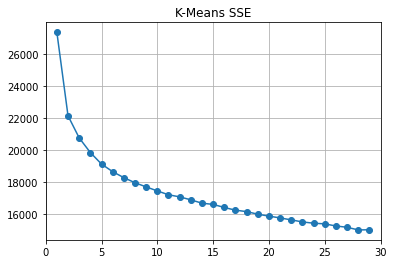

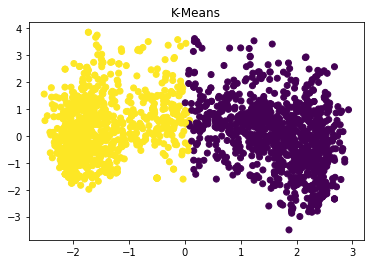

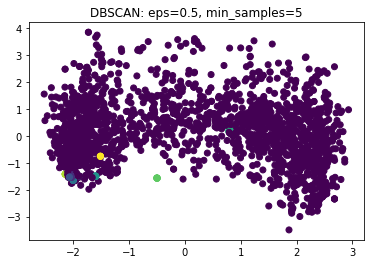

Estimated number of clusters: 8
Estimated number of noise points: 1853


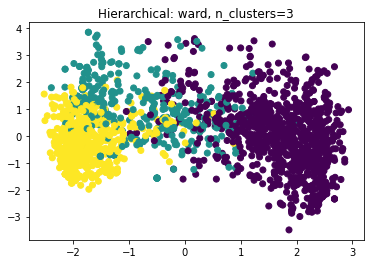

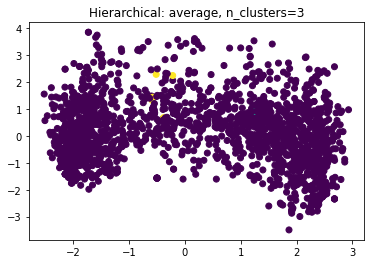

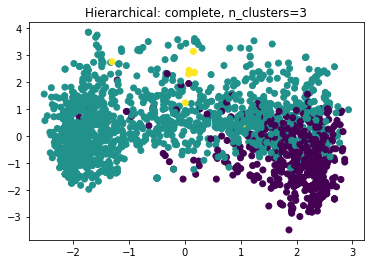

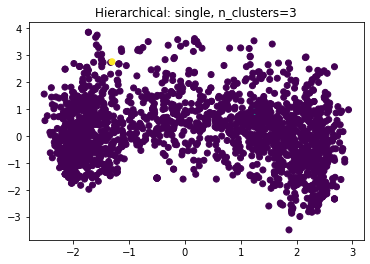

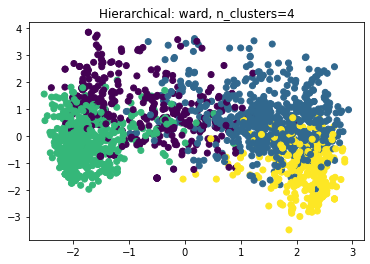

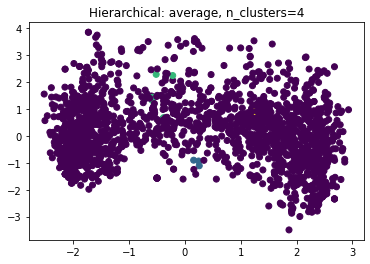

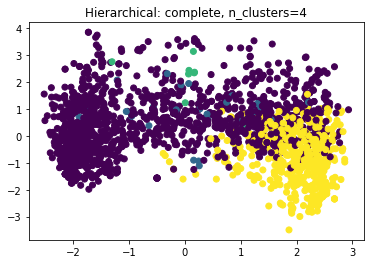

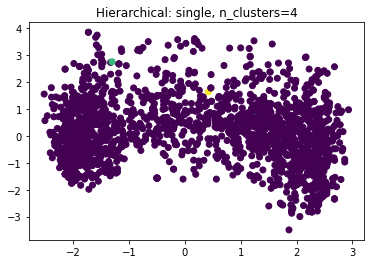

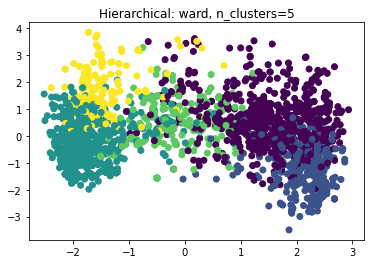

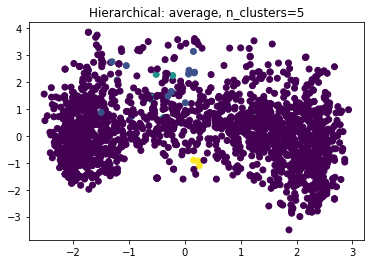

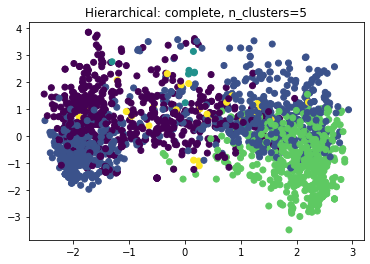

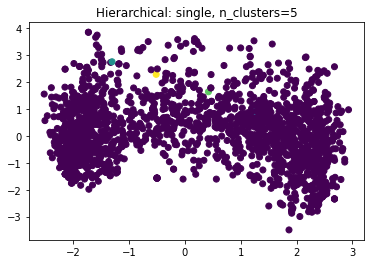

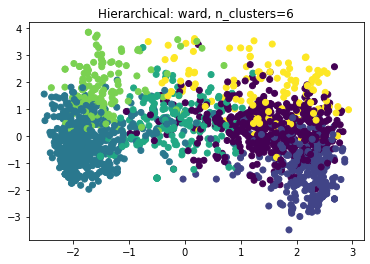

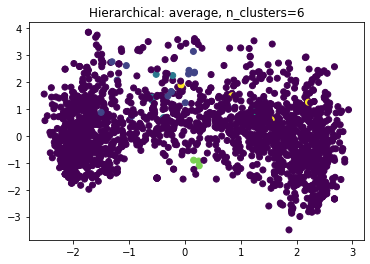

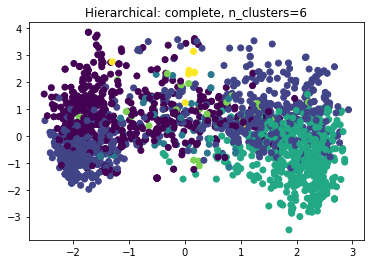

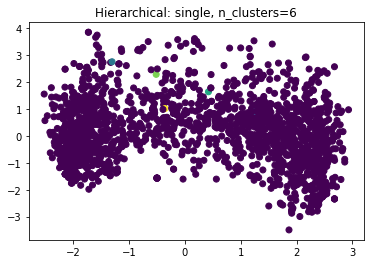

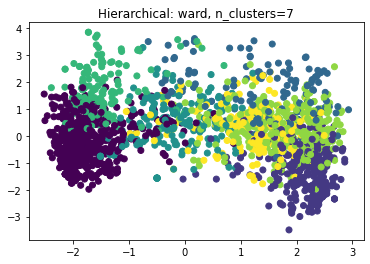

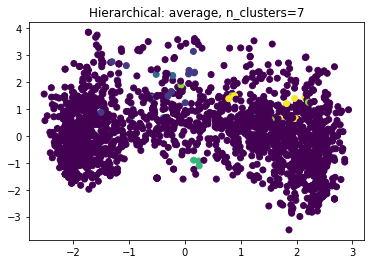

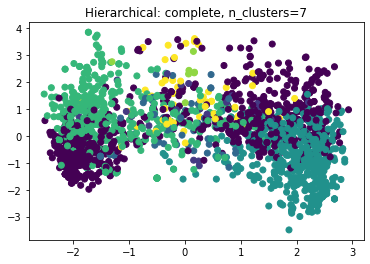

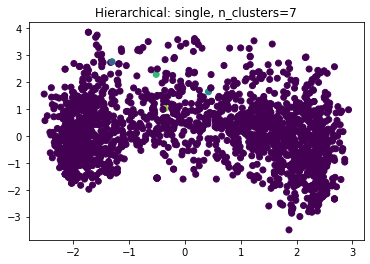

Finishing Program


In [27]:
# apply PCA to reduce the dimensionality of the embeddings
reduced_embeddings = PCA(n_components = 2, random_state=2).fit_transform(np_pop_embs)

# compute SSE (sum squared error) vs number of clusters and find the "elbow point", the point after
# which the SSE or inertia starts decreasing in linear fashion
sse = compute_kmeans_sse(np_pop_embs, 30)

# apply k means
kmeans_n_clusters = 2
kmeans = KMeans(n_clusters = kmeans_n_clusters, n_init = 20, random_state = 10)
kmeans.fit(np_pop_embs)

plt.scatter(reduced_embeddings[:,0], reduced_embeddings[:,1], c=kmeans.labels_)
plt.title("K-Means")
#plt.savefig(os.path.join(saved_plt_path, "Kmeans"))
plt.show()

eps = 0.5
min_samples = 5

# DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(np_pop_embs)
plt.scatter(reduced_embeddings[:,0], reduced_embeddings[:,1], c=dbscan.labels_)
plt.title(f"DBSCAN: eps={eps}, min_samples={min_samples}")
#plt.savefig(os.path.join(saved_plt_path, "DBSCAN"))
plt.show()

dbscan_2 = DBSCAN(eps=eps, min_samples=min_samples).fit(np_pop_embs)
labels = dbscan_2.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)


#record_res.write("DBSCAN\n")
str_clusters = "Estimated number of clusters: %d" % n_clusters_
str_noise = "Estimated number of noise points: %d" % n_noise_

#record_res.write(str_clusters + "\n")
#record_res.write(str_noise + "\n")

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Agglomerative Clustering
# for clusters from 3 to 8, and the 4 linkage criteria
n_clusters = range(3,8)
linkage = ["ward", "average", "complete", "single"]


save_labels = []
for k in n_clusters:
    for criteria in linkage:
        clust = AgglomerativeClustering(n_clusters=k, linkage=criteria).fit(np_pop_embs)
        plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clust.labels_)
        plt.title(f"Hierarchical: {criteria}, n_clusters={k}")
        #plt.savefig(os.path.join(saved_plt_path, f"AgglomerativeClustering~{k}~{criteria}"))
        plt.show()

print("Finishing Program")

**SCREEN2VEC EMBEDDINGS**

C:\Users\rober_abgp8xd\anaconda3\envs\CAD_work\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[9211.7626953125, 4012.091796875, 2661.7822265625, 1814.9417724609375, 1511.72412109375, 1224.010986328125, 1002.342041015625, 888.6678466796875, 791.45703125, 687.5794677734375, 621.7198486328125, 562.4071044921875, 517.7424926757812, 485.33123779296875, 443.23419189453125, 413.6996154785156, 386.955078125, 368.27484130859375, 344.762939453125, 334.7040710449219, 319.1169738769531, 298.3841247558594, 286.5002746582031, 275.04766845703125, 263.4064025878906, 252.668701171875, 243.691650390625, 235.36477661132812, 226.1288299560547]


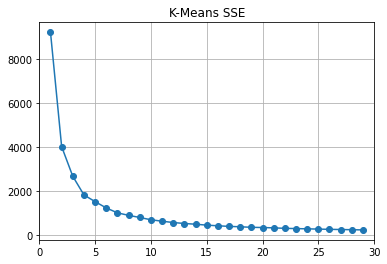

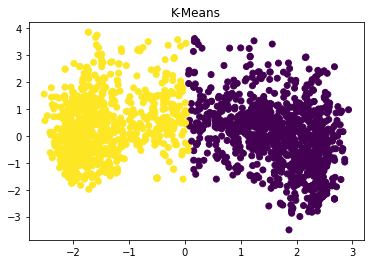

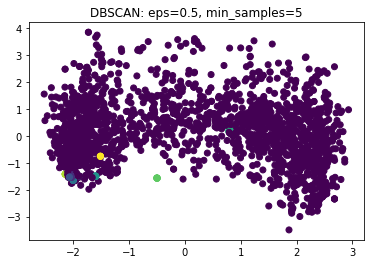

Estimated number of clusters: 8
Estimated number of noise points: 1853


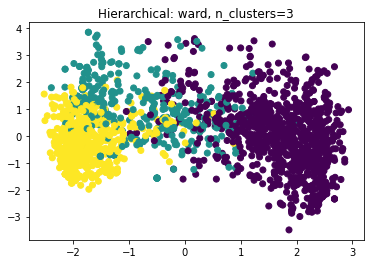

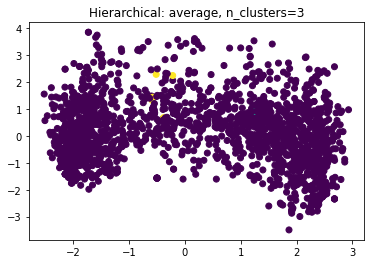

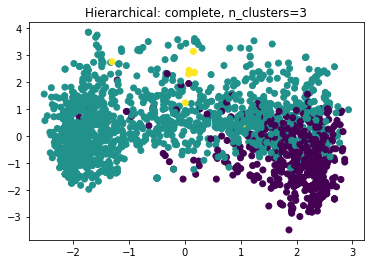

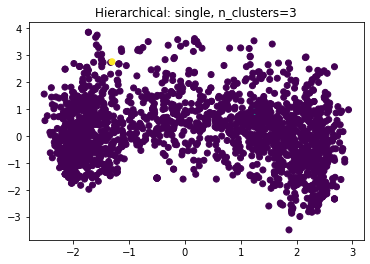

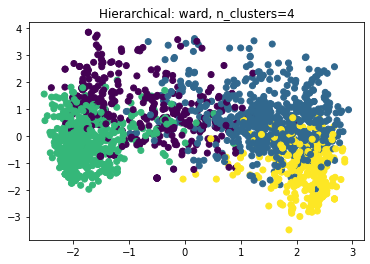

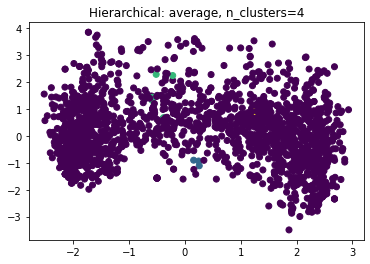

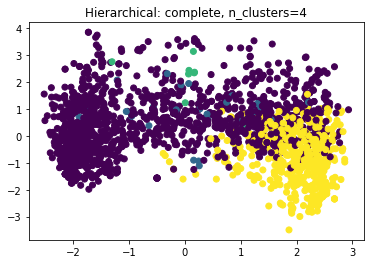

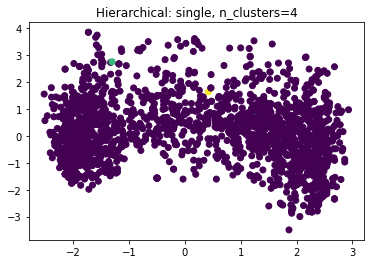

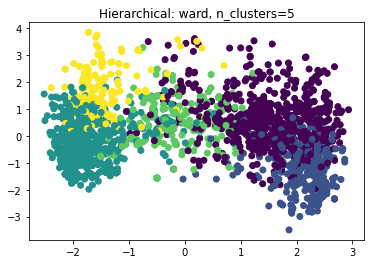

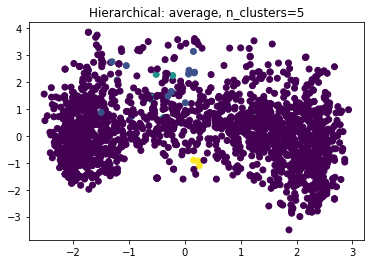

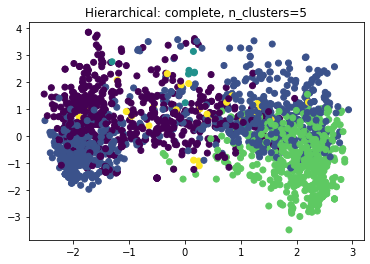

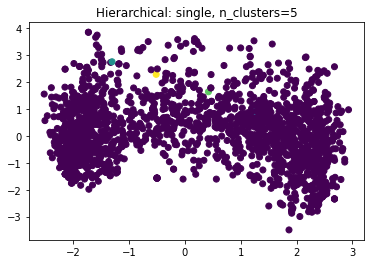

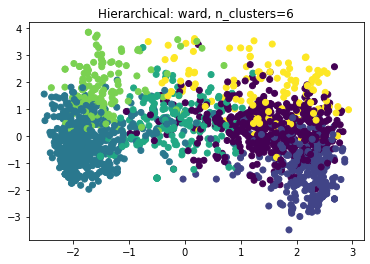

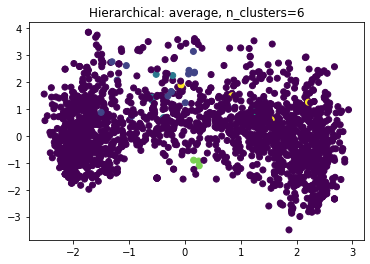

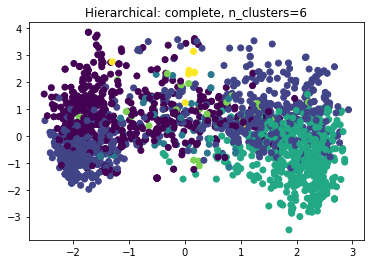

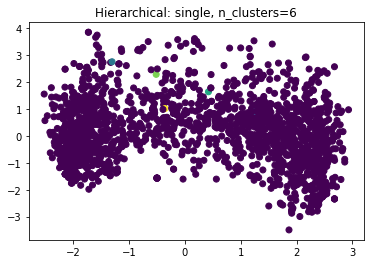

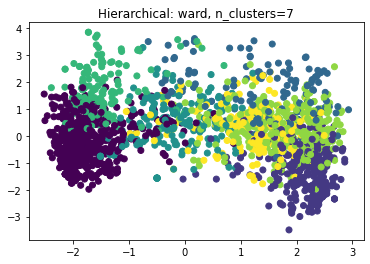

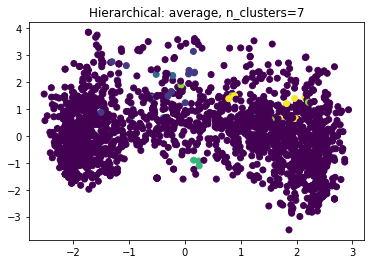

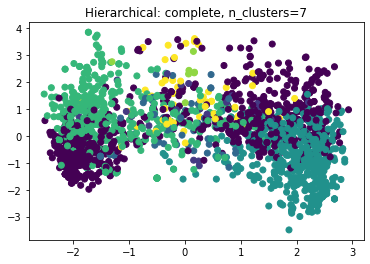

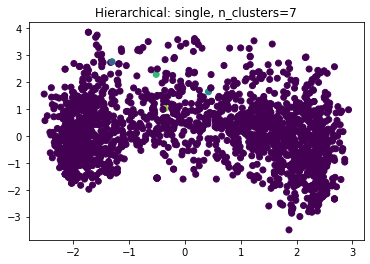

Finishing Program


In [28]:
# apply PCA to reduce the dimensionality of the embeddings
reduced_embeddings = PCA(n_components = 2, random_state=2).fit_transform(np_pop_embs)

# compute SSE (sum squared error) vs number of clusters and find the "elbow point", the point after
# which the SSE or inertia starts decreasing in linear fashion
sse = compute_kmeans_sse(reduced_embeddings, 30)

# apply k means
kmeans_n_clusters = 2
kmeans = KMeans(n_clusters = kmeans_n_clusters, n_init = 20, random_state = 10)
kmeans.fit(reduced_embeddings)

plt.scatter(reduced_embeddings[:,0], reduced_embeddings[:,1], c=kmeans.labels_)
plt.title("K-Means")
#plt.savefig(os.path.join(saved_plt_path, "Kmeans"))
plt.show()

eps = 0.5
min_samples = 5

# DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(np_pop_embs)
plt.scatter(reduced_embeddings[:,0], reduced_embeddings[:,1], c=dbscan.labels_)
plt.title(f"DBSCAN: eps={eps}, min_samples={min_samples}")
#plt.savefig(os.path.join(saved_plt_path, "DBSCAN"))
plt.show()

dbscan_2 = DBSCAN(eps=eps, min_samples=min_samples).fit(np_pop_embs)
labels = dbscan_2.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)


#record_res.write("DBSCAN\n")
str_clusters = "Estimated number of clusters: %d" % n_clusters_
str_noise = "Estimated number of noise points: %d" % n_noise_

#record_res.write(str_clusters + "\n")
#record_res.write(str_noise + "\n")

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Agglomerative Clustering
# for clusters from 3 to 8, and the 4 linkage criteria
n_clusters = range(3,8)
linkage = ["ward", "average", "complete", "single"]


save_labels = []
for k in n_clusters:
    for criteria in linkage:
        clust = AgglomerativeClustering(n_clusters=k, linkage=criteria).fit(np_pop_embs)
        plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clust.labels_)
        plt.title(f"Hierarchical: {criteria}, n_clusters={k}")
        #plt.savefig(os.path.join(saved_plt_path, f"AgglomerativeClustering~{k}~{criteria}"))
        plt.show()

print("Finishing Program")

**Apply UMAP and clustering algorithms to popular screenshots embeddings**

**LAYOUT EMBEDDINGS**

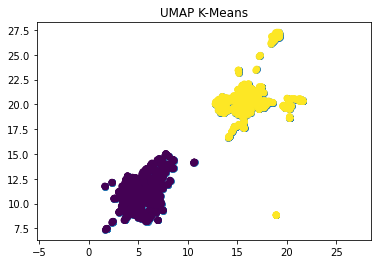

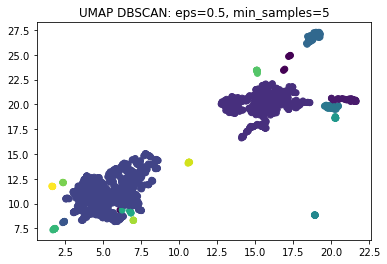

Estimated number of clusters: 15
Estimated number of noise points: 6


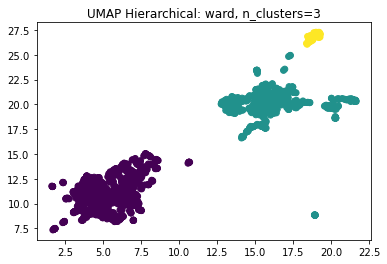

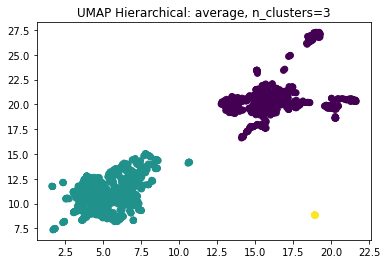

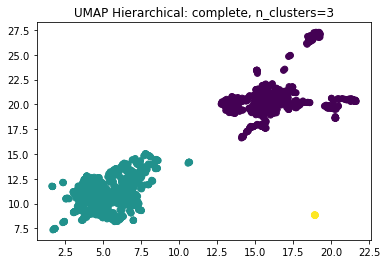

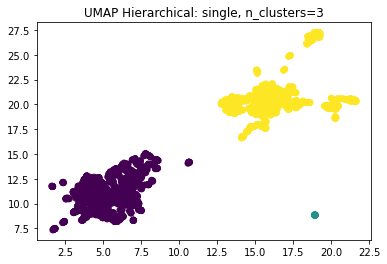

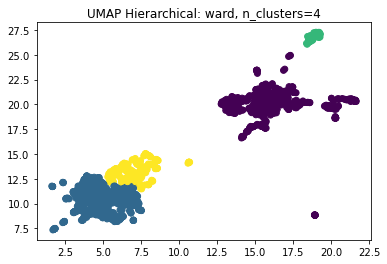

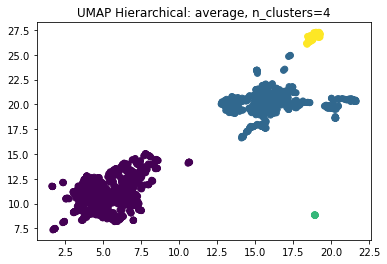

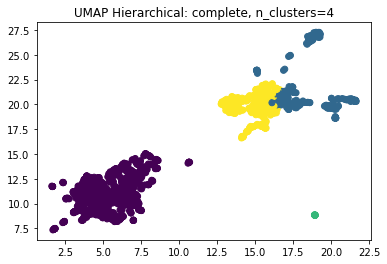

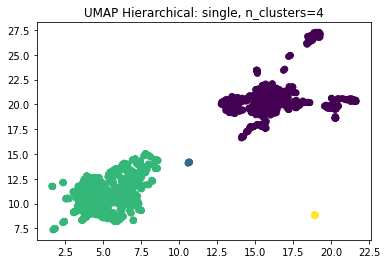

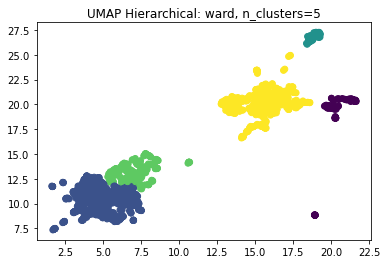

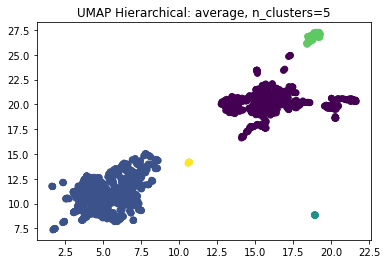

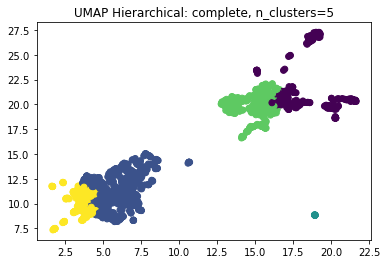

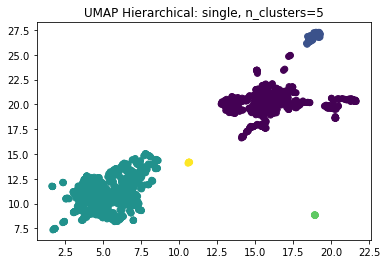

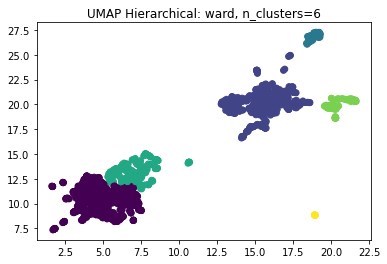

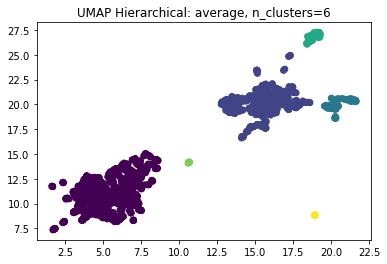

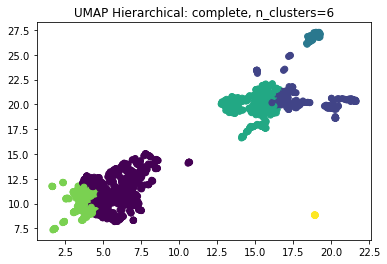

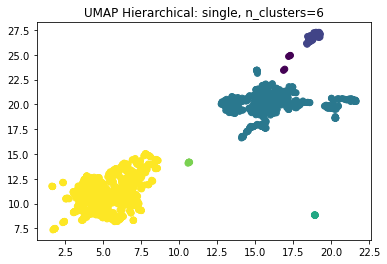

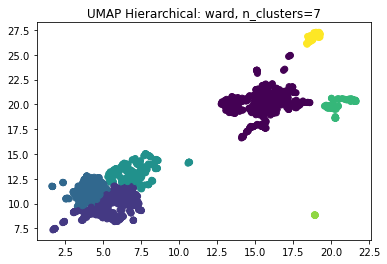

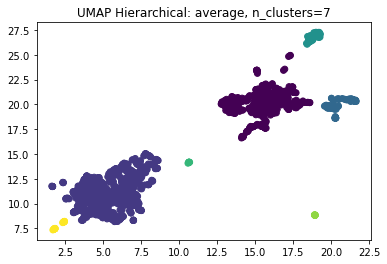

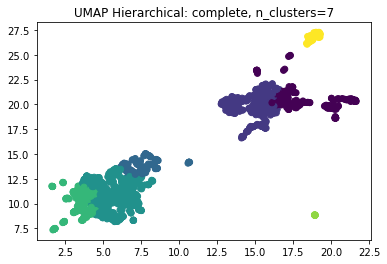

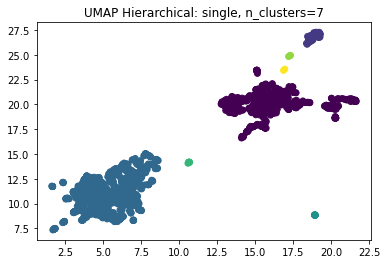

Finishing Program


In [46]:
reducer = umap.UMAP(random_state=4)
umap_embeddings = reducer.fit_transform(np_pop_embs)

plt.scatter(
    umap_embeddings[:, 0],
    umap_embeddings[:, 1],
    #c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
)
plt.gca().set_aspect('equal', 'datalim')
plt.savefig(os.path.join(saved_plt_path, "UMAP_reduction"))
plt.title('UMAP Dimension reduction algorithm', fontsize=24)

# apply k means
kmeans_n_clusters = 4
kmeans = KMeans(n_clusters = kmeans_n_clusters, n_init = 20, random_state = 2)
kmeans.fit(umap_embeddings)

plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1], c=kmeans.labels_)
plt.title("UMAP K-Means")
plt.savefig(os.path.join(saved_plt_path, "UMAP Kmeans"))
plt.show()

eps = 0.5
min_samples = 5

# DBSCAN
umap_dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(umap_embeddings)
plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1], c=umap_dbscan.labels_)
plt.title(f"UMAP DBSCAN: eps={eps}, min_samples={min_samples}")
plt.savefig(os.path.join(saved_plt_path, "umap_DBSCAN"))
plt.show()

umap_dbscan_2 = DBSCAN(eps=eps, min_samples=min_samples).fit(umap_embeddings)
umap_labels = umap_dbscan_2.labels_
n_clusters_ = len(set(umap_labels)) - (1 if -1 in umap_labels else 0)
n_noise_ = list(umap_labels).count(-1)


#record_res.write("DBSCAN\n")
str_clusters = "Estimated number of clusters: %d" % n_clusters_
str_noise = "Estimated number of noise points: %d" % n_noise_

#record_res.write(str_clusters + "\n")
#record_res.write(str_noise + "\n")

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Agglomerative Clustering
# for clusters from 3 to 8, and the 4 linkage criteria
n_clusters = range(3,8)
linkage = ["ward", "average", "complete", "single"]


save_labels = []
for k in n_clusters:
    for criteria in linkage:
        clust = AgglomerativeClustering(n_clusters=k, linkage=criteria).fit(umap_embeddings)
        plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=clust.labels_)
        plt.title(f"UMAP Hierarchical: {criteria}, n_clusters={k}")
        plt.savefig(os.path.join(saved_plt_path, f"UMAP AgglomerativeClustering~{k}~{criteria}"))
        plt.show()

print("Finishing Program")

**SCREEN2VEC EMBEDDINGS**

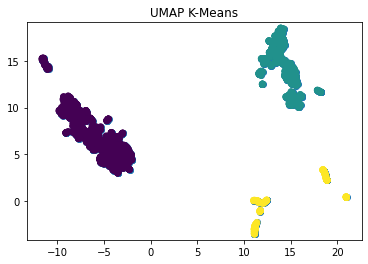

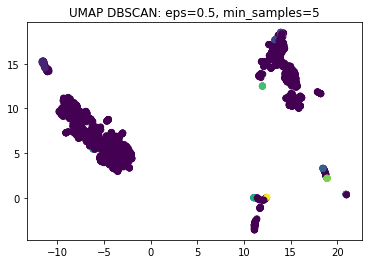

Estimated number of clusters: 10
Estimated number of noise points: 1878


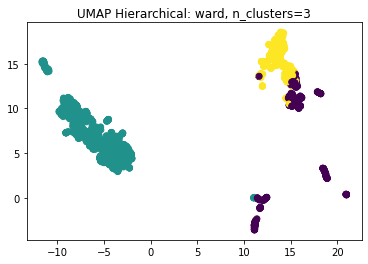

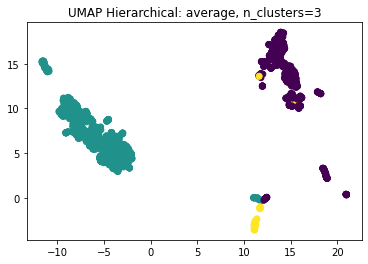

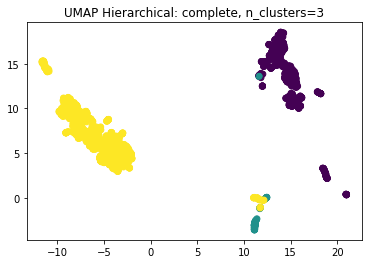

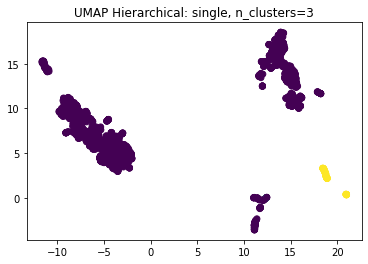

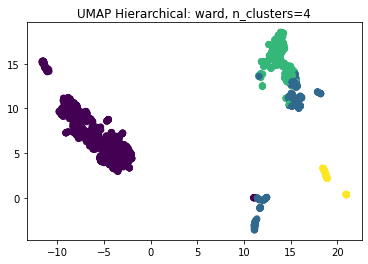

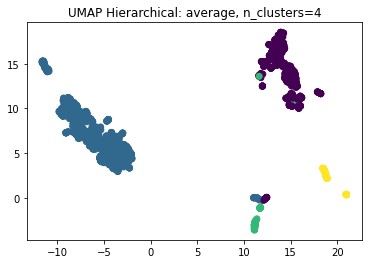

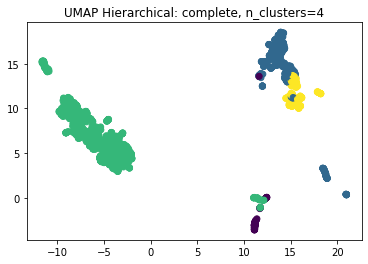

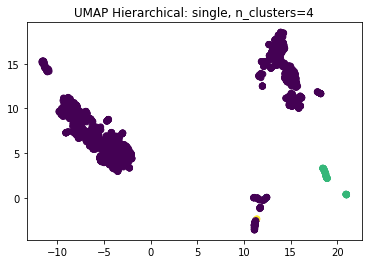

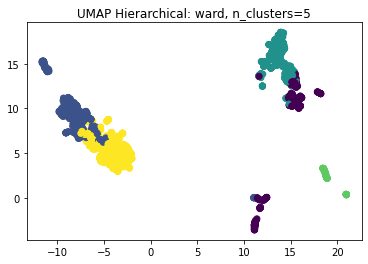

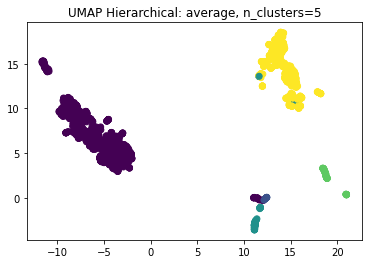

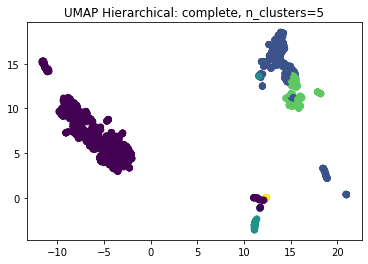

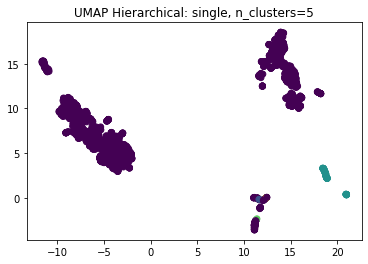

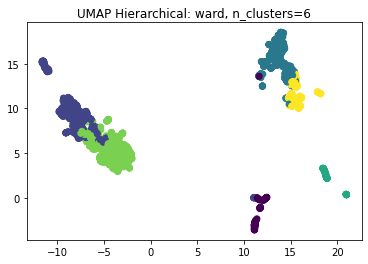

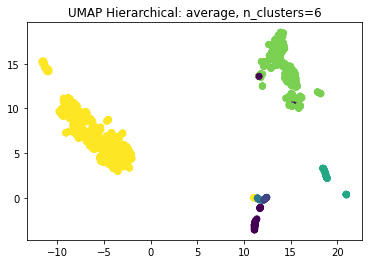

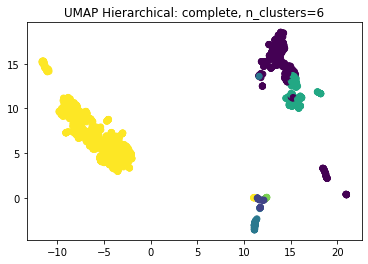

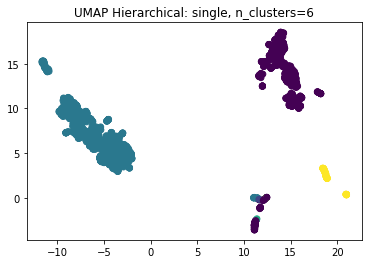

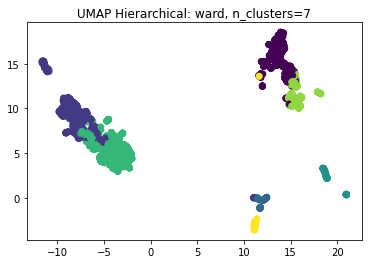

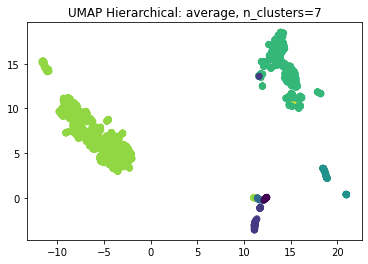

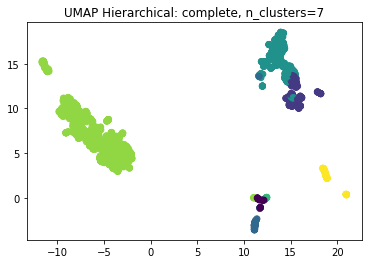

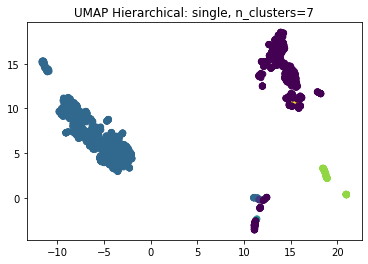

Finishing Program


In [29]:
reducer = umap.UMAP(random_state=4)
umap_embeddings = reducer.fit_transform(np_pop_embs)

plt.scatter(
    umap_embeddings[:, 0],
    umap_embeddings[:, 1],
    #c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
)
plt.gca().set_aspect('equal', 'datalim')
plt.savefig(os.path.join(saved_plt_path, "UMAP_reduction"))
plt.title('UMAP Dimension reduction algorithm', fontsize=24)

# apply k means
kmeans_n_clusters = 3
kmeans = KMeans(n_clusters = kmeans_n_clusters, n_init = 20, random_state = 2)
kmeans.fit(umap_embeddings)

plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1], c=kmeans.labels_)
plt.title("UMAP K-Means")
plt.savefig(os.path.join(saved_plt_path, "UMAP Kmeans"))
plt.show()

eps = 0.5
min_samples = 5

# DBSCAN
umap_dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(np_pop_embs)
plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1], c=umap_dbscan.labels_)
plt.title(f"UMAP DBSCAN: eps={eps}, min_samples={min_samples}")
plt.savefig(os.path.join(saved_plt_path, "umap_DBSCAN"))
plt.show()

umap_dbscan_2 = DBSCAN(eps=eps, min_samples=min_samples).fit(np_pop_embs)
umap_labels = umap_dbscan_2.labels_
n_clusters_ = len(set(umap_labels)) - (1 if -1 in umap_labels else 0)
n_noise_ = list(umap_labels).count(-1)


#record_res.write("DBSCAN\n")
str_clusters = "Estimated number of clusters: %d" % n_clusters_
str_noise = "Estimated number of noise points: %d" % n_noise_

#record_res.write(str_clusters + "\n")
#record_res.write(str_noise + "\n")

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Agglomerative Clustering
# for clusters from 3 to 8, and the 4 linkage criteria
n_clusters = range(3,8)
linkage = ["ward", "average", "complete", "single"]


save_labels = []
for k in n_clusters:
    for criteria in linkage:
        clust = AgglomerativeClustering(n_clusters=k, linkage=criteria).fit(np_pop_embs)
        plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=clust.labels_)
        plt.title(f"UMAP Hierarchical: {criteria}, n_clusters={k}")
        plt.savefig(os.path.join(saved_plt_path, f"UMAP AgglomerativeClustering~{k}~{criteria}"))
        plt.show()

print("Finishing Program")

**Show examples from each cluster**

**LAYOUT EMBEDDINGS**

In [29]:
# computes reduced embedding vectors
print(np_pop_embs.shape)
umap.UMAP(random_state = 4)

reduced_embeddings = reducer.fit_transform(np_pop_embs)

# apply k means
kmeans_n_clusters = 7
kmeans = KMeans(n_clusters = kmeans_n_clusters, n_init = 100, random_state = 9)
kmeans.fit(np_pop_embs)

sc = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=kmeans.labels_)
plt.title(f"UMAP kmeans; n_clusters={kmeans_n_clusters}")
plt.legend(*sc.legend_elements(), title='clusters')
plt.savefig(os.path.join(cluster_examples, f"Best example - Popular screenshots UMAP Kmeans~{kmeans_n_clusters}"))
plt.show()

save_labels = kmeans.labels_

(2022, 64)


NameError: name 'reducer' is not defined

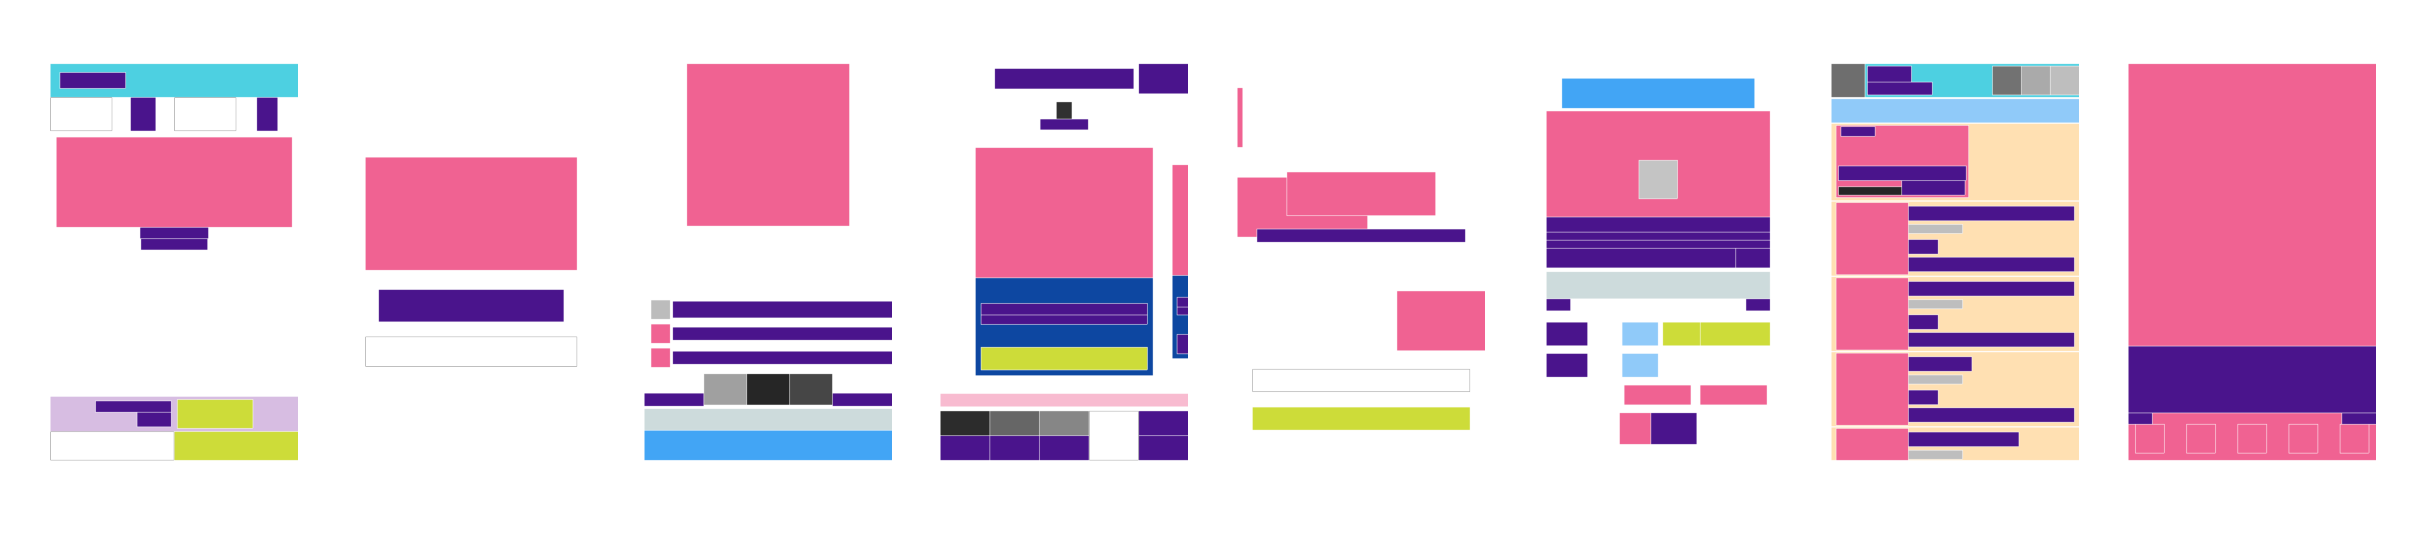

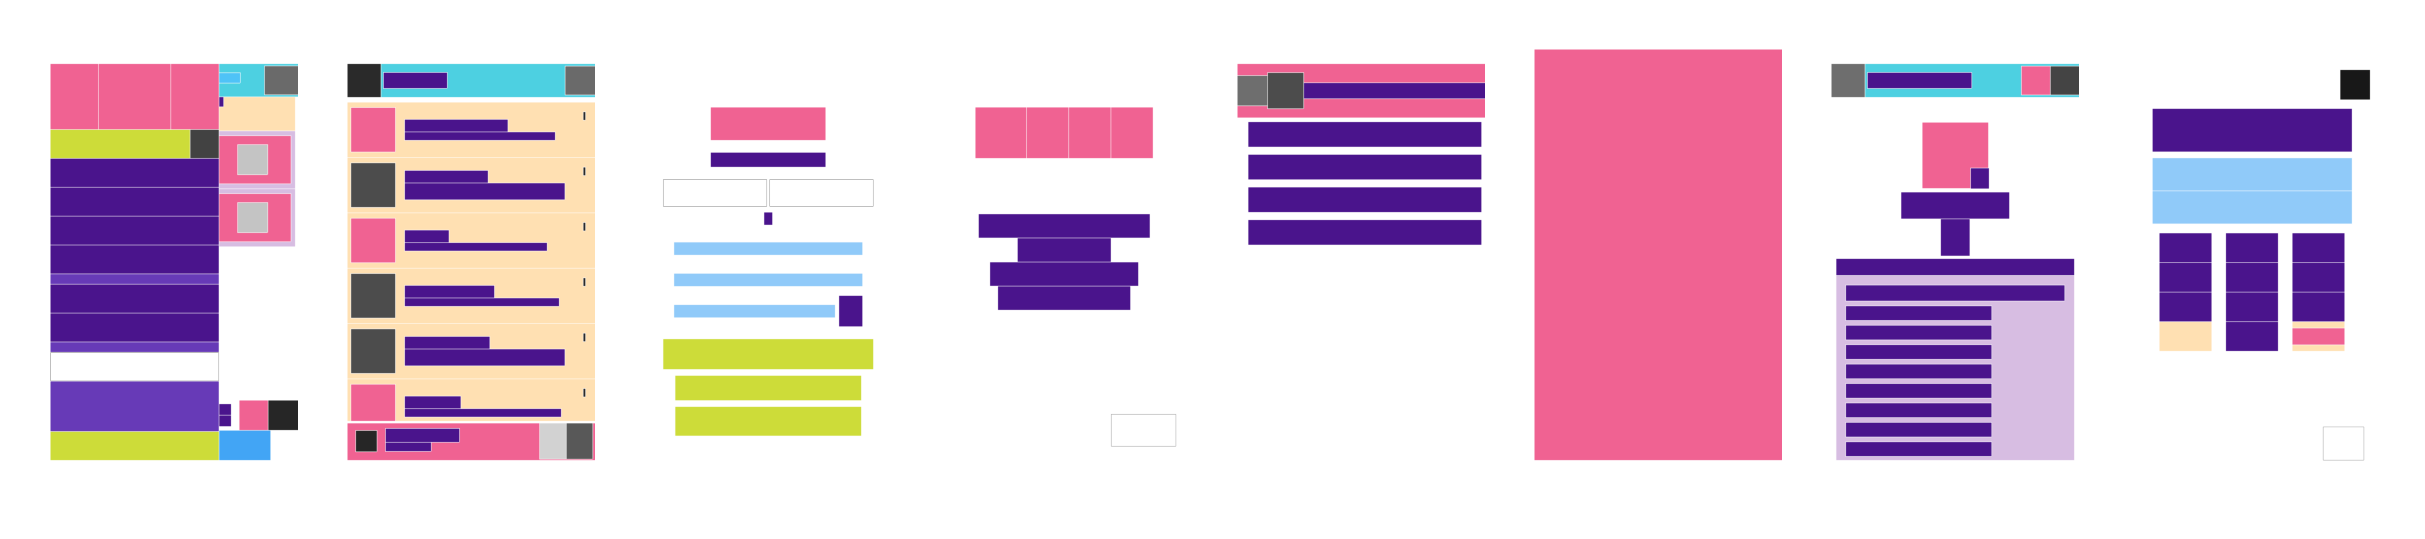

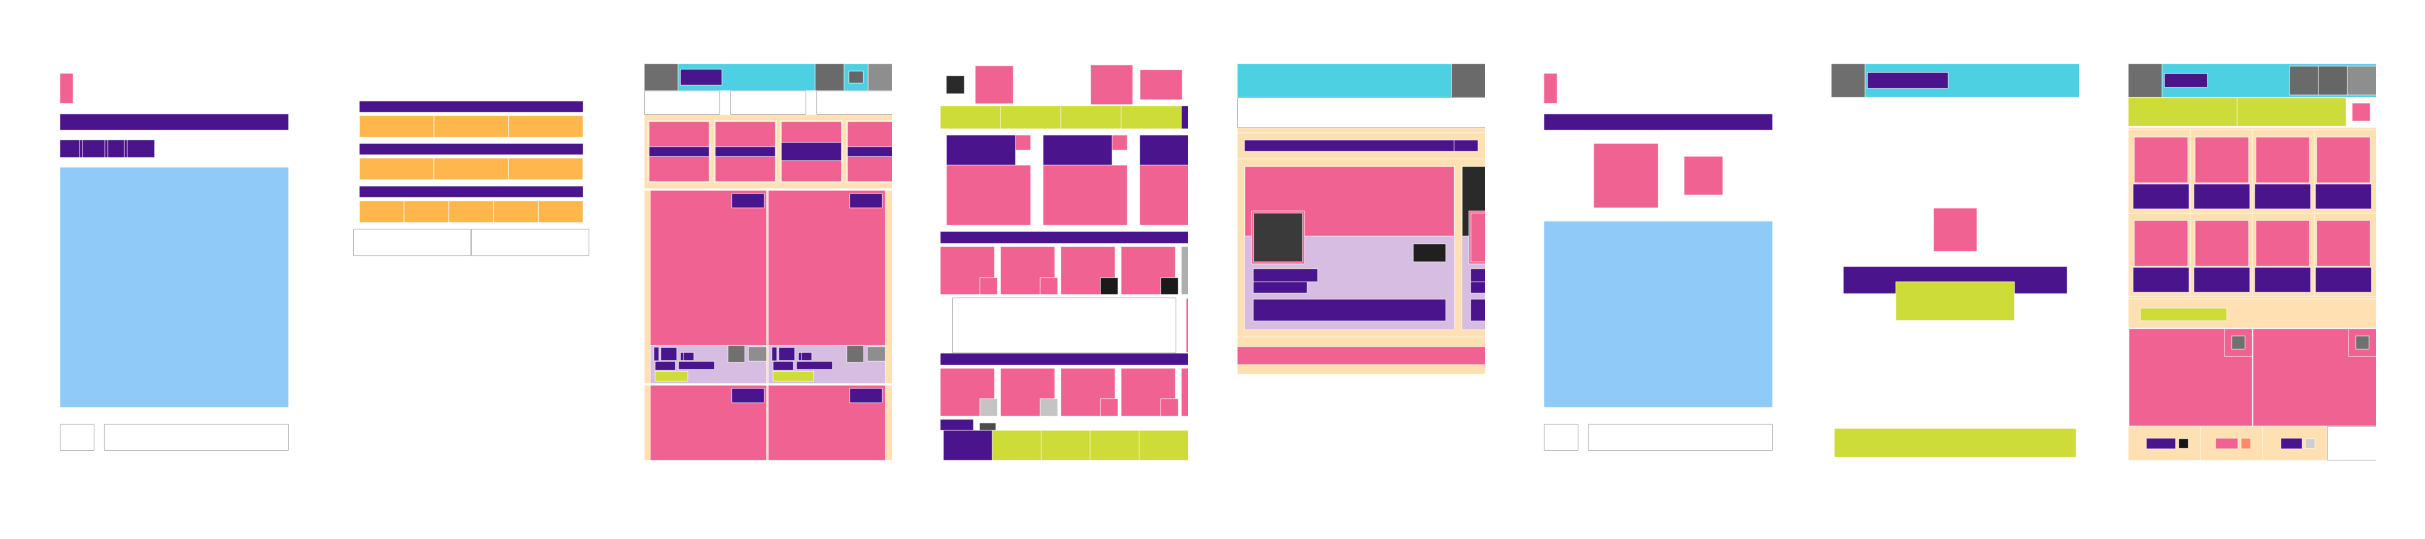

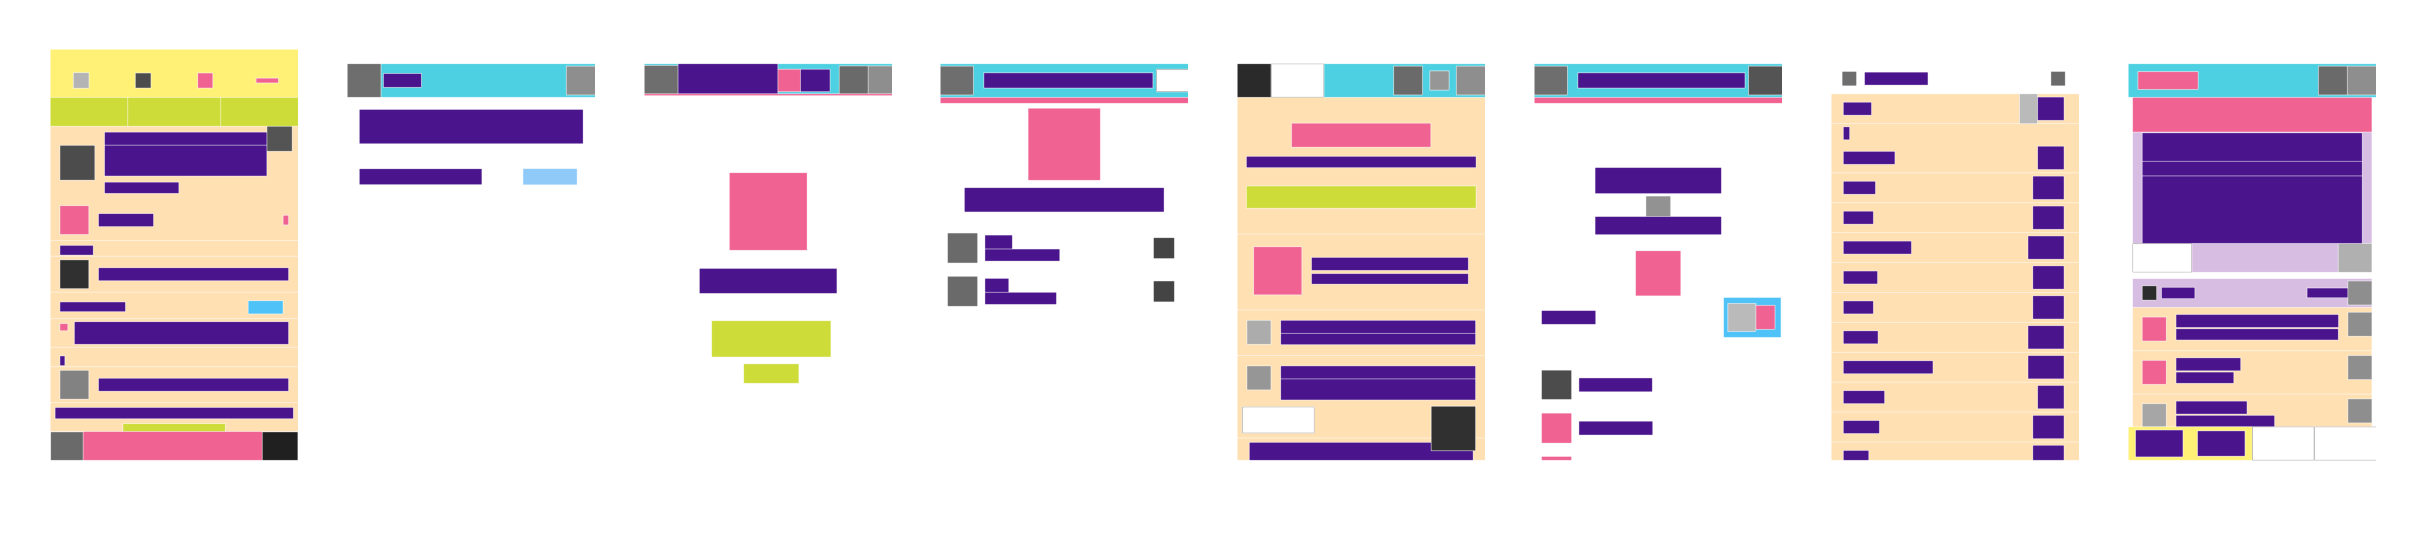

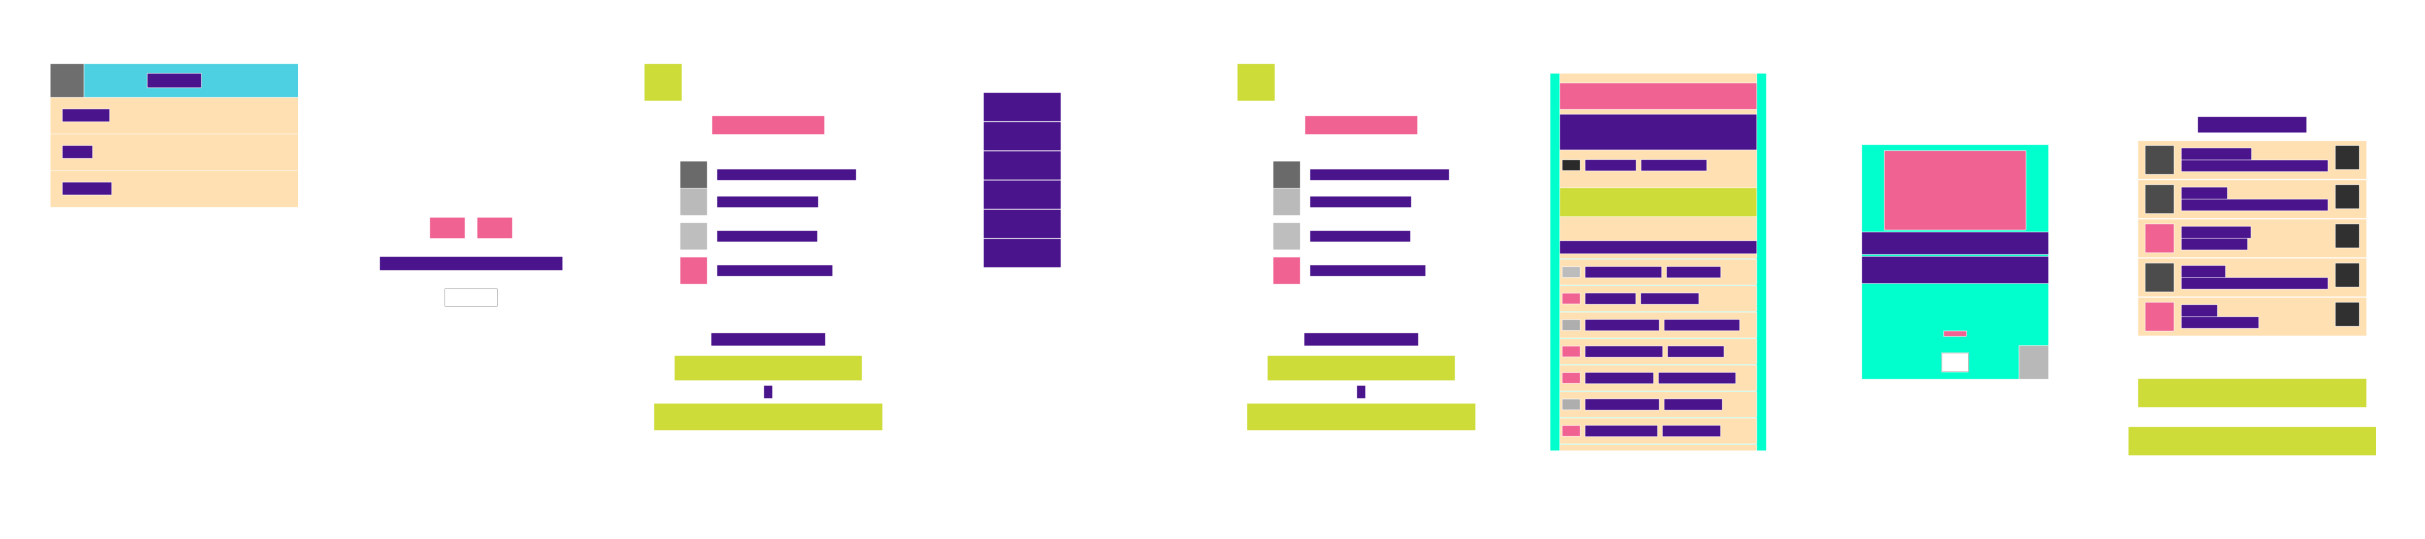

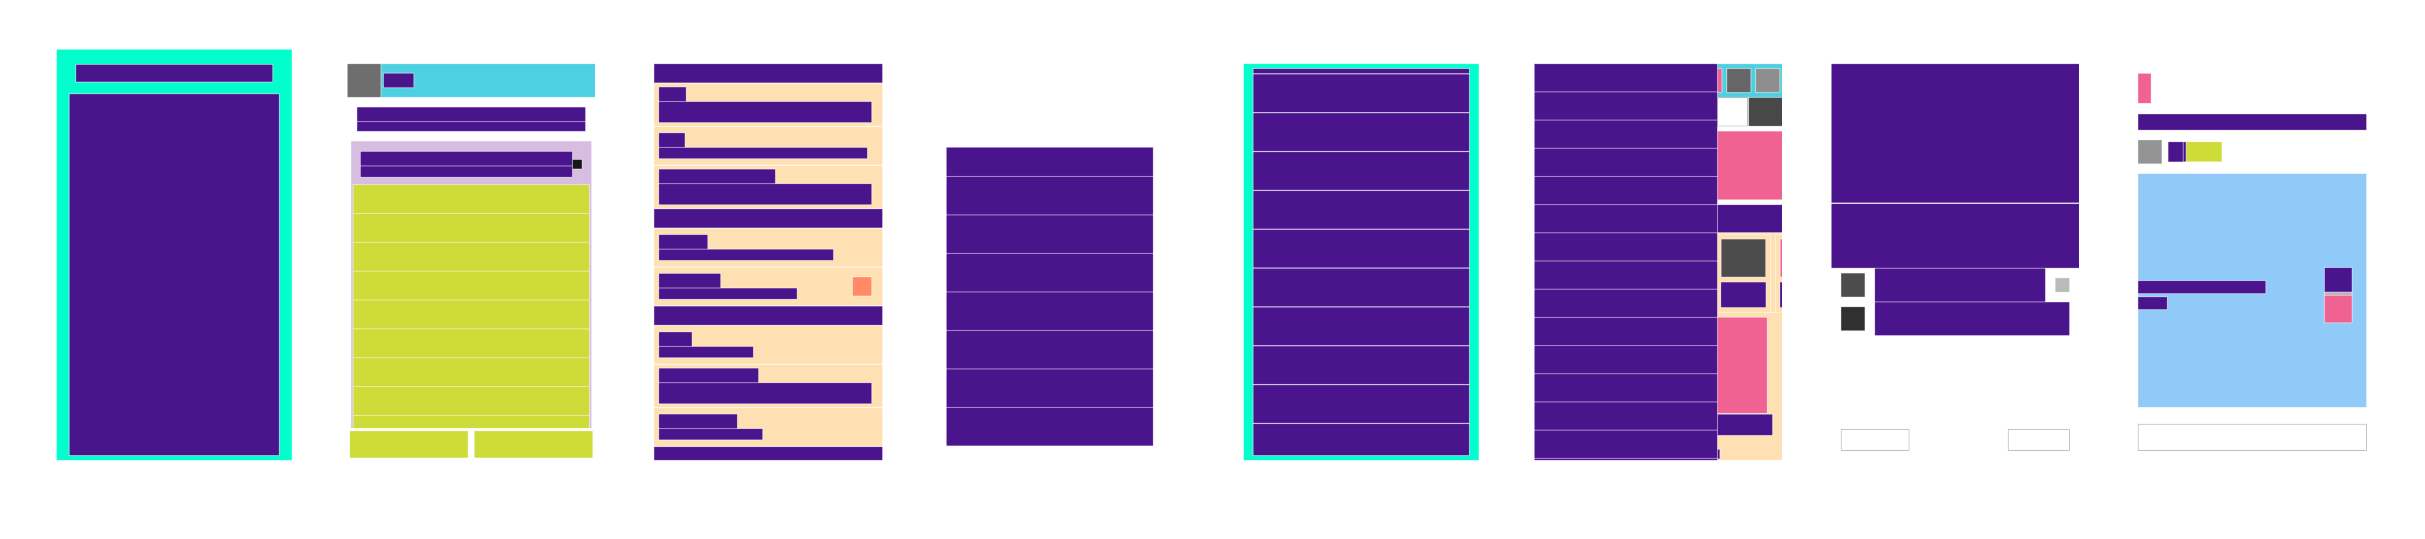

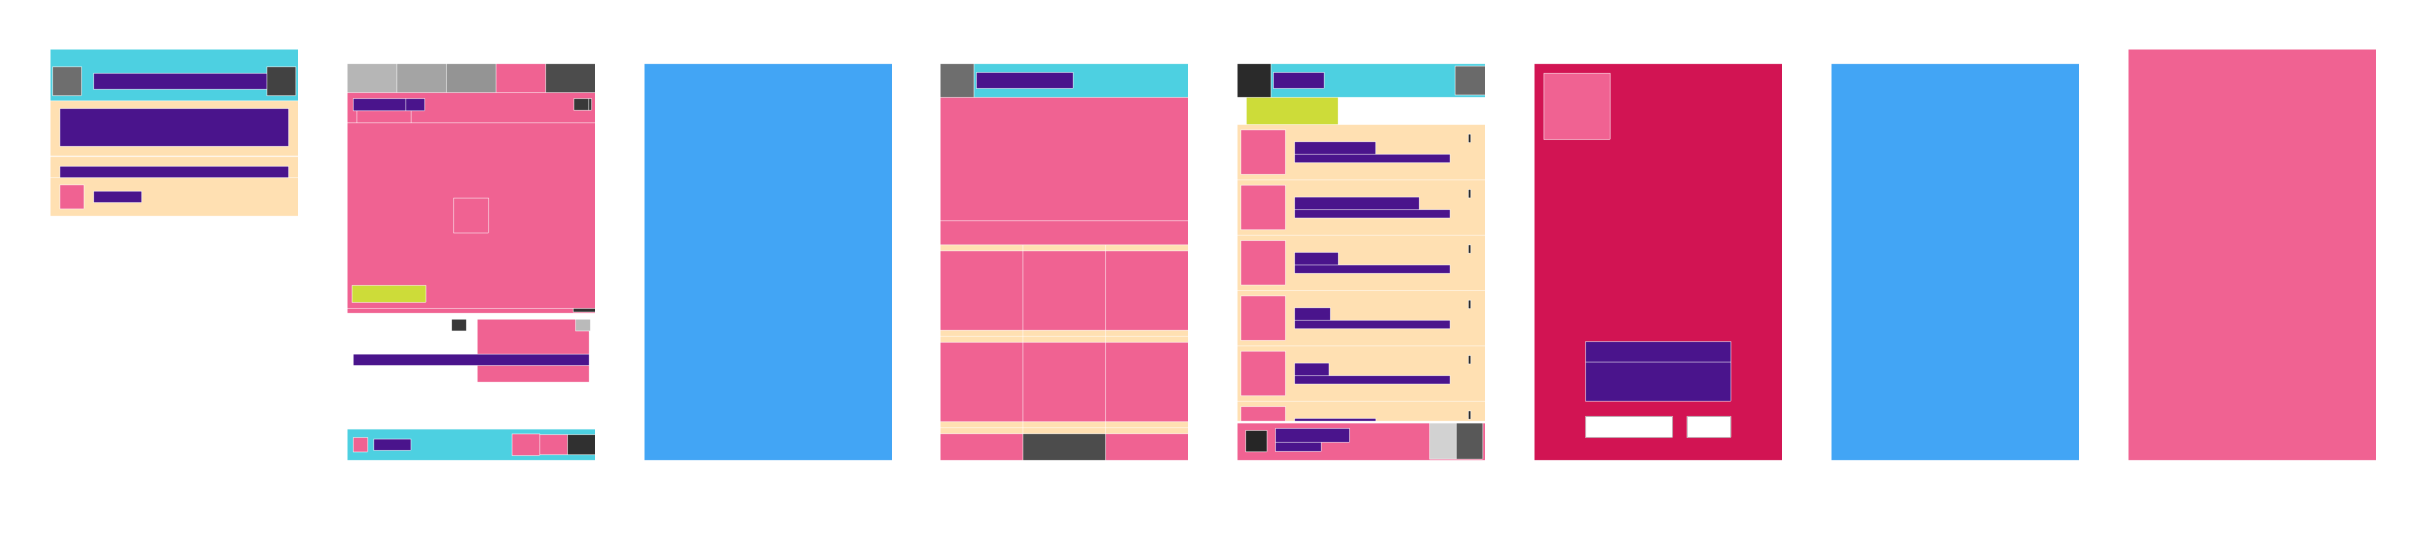

In [80]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

# figure size in inches optional

%matplotlib inline

clusters_labels = [0, 1, 2, 3, 4, 5, 6]
for i in clusters_labels:
    # popular_finall_df["ui_id"].values
    clust_examples = get_random_popular_examples(save_labels, i, 8, popular_finall_df["ui_id"].values)
    #print(list(clust_examples))

    # display images
    fig, ax = plt.subplots(1,8)
    fig.set_dpi(500)
    lista=[]
    
    # testing and making sure the results are correct
    #for j in range(len(clust_examples)):
        #saved_popular_tensors = os.path.join(os.getcwd(), "popular_layouts_folder_97")
        
        #iembed = torch.load(os.path.join(saved_popular_tensors, f"{clust_examples[j]}.pt"))
        #gets numpy embeddings from the embeddings
        #numpy_embeddings = ((iembed.detach()).numpy()).reshape(1,-1)
        #reduced_emb = reducer.transform(numpy_embeddings)
        #print(reduced_emb.shape)
        #lista.append(kmeans.predict(reduced_emb)[0])
    
    
    #print(lista)
    
    for j in range(len(clust_examples)):
        filename = os.path.join(rico_layout_dataset, f"{clust_examples[j]}.png")
        img = mpimg.imread(filename)
        ax[j].imshow(img)
        ax[j].axis('off')

    fig.savefig(os.path.join(cluster_examples,f"example{i}.jpg"), dpi=fig.dpi)

**SCREEN2VEC EMBEDDINGS**

(2022, 768)


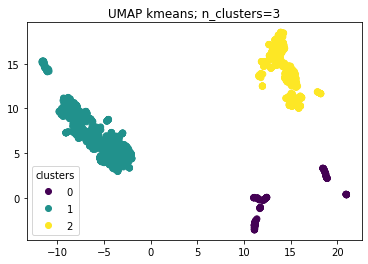

In [58]:
# computes reduced embedding vectors
print(np_pop_embs.shape)
umap.UMAP(random_state = 4)

reduced_embeddings = reducer.fit_transform(np_pop_embs)

# apply k means
kmeans_n_clusters = 3
kmeans = KMeans(n_clusters = kmeans_n_clusters, n_init = 100, random_state = 9)
kmeans.fit(reduced_embeddings)

sc = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=kmeans.labels_)
plt.title(f"UMAP kmeans; n_clusters={kmeans_n_clusters}")
plt.legend(*sc.legend_elements(), title='clusters')
plt.savefig(os.path.join(cluster_examples, f"Best example - Popular screenshots UMAP Kmeans~{kmeans_n_clusters}"))
plt.show()

save_labels = kmeans.labels_

[0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1]
[2, 2, 2, 2, 2, 2, 2, 2]


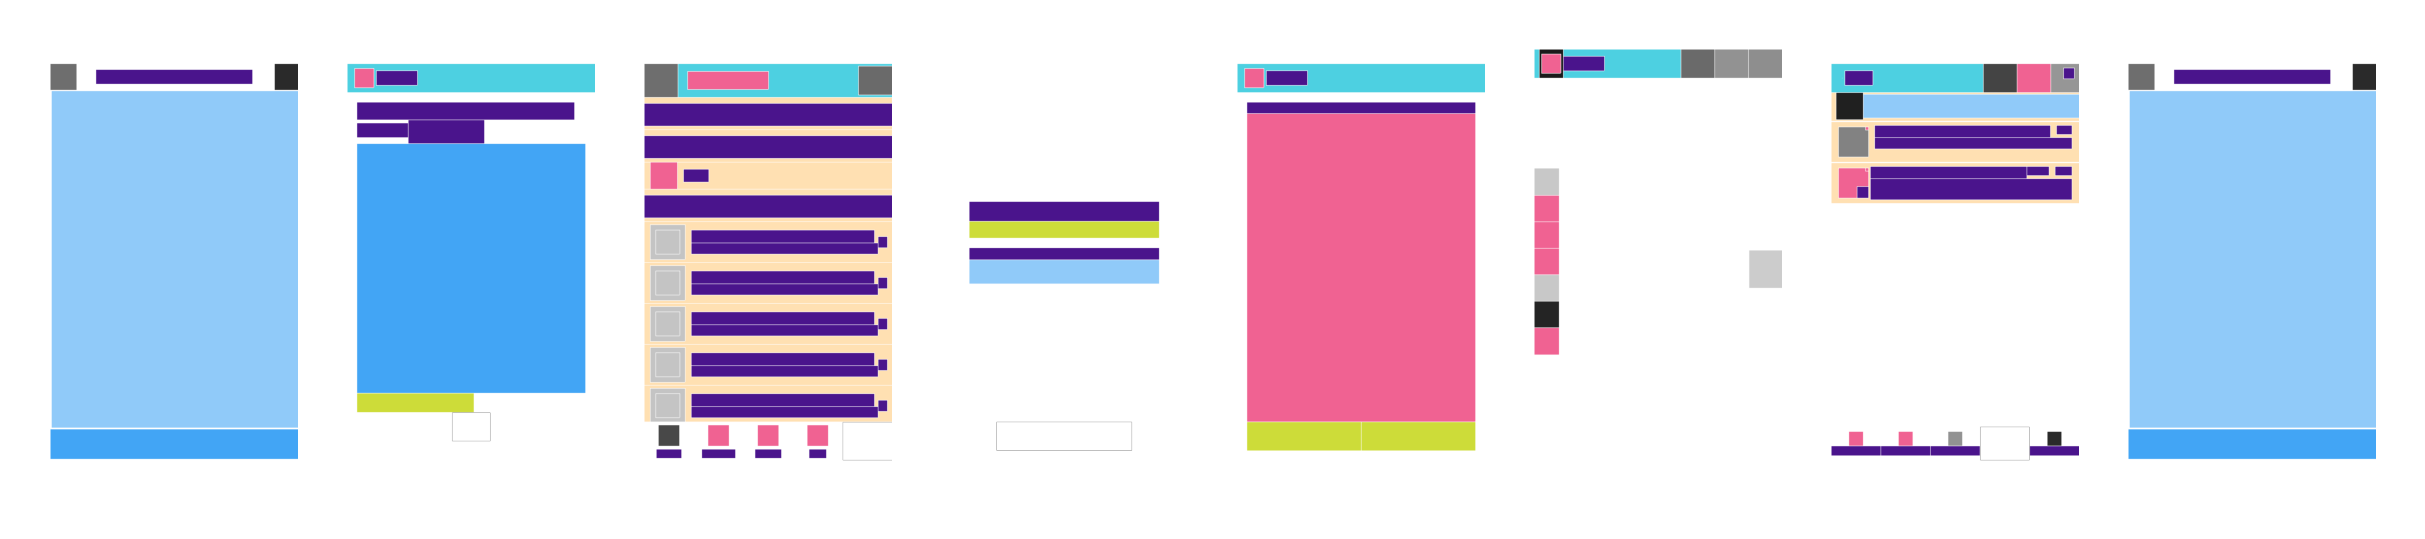

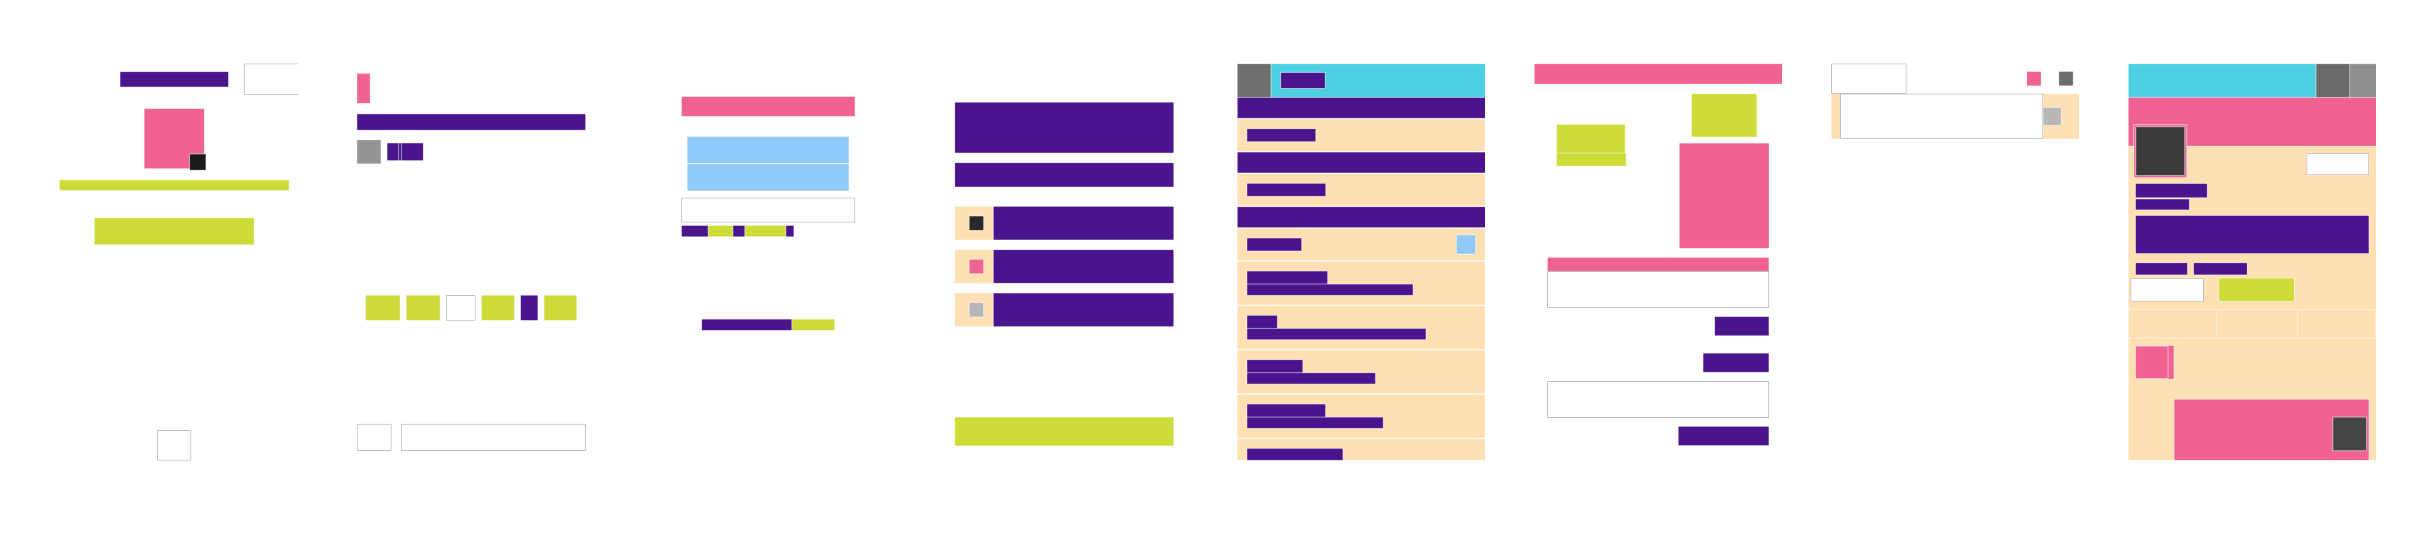

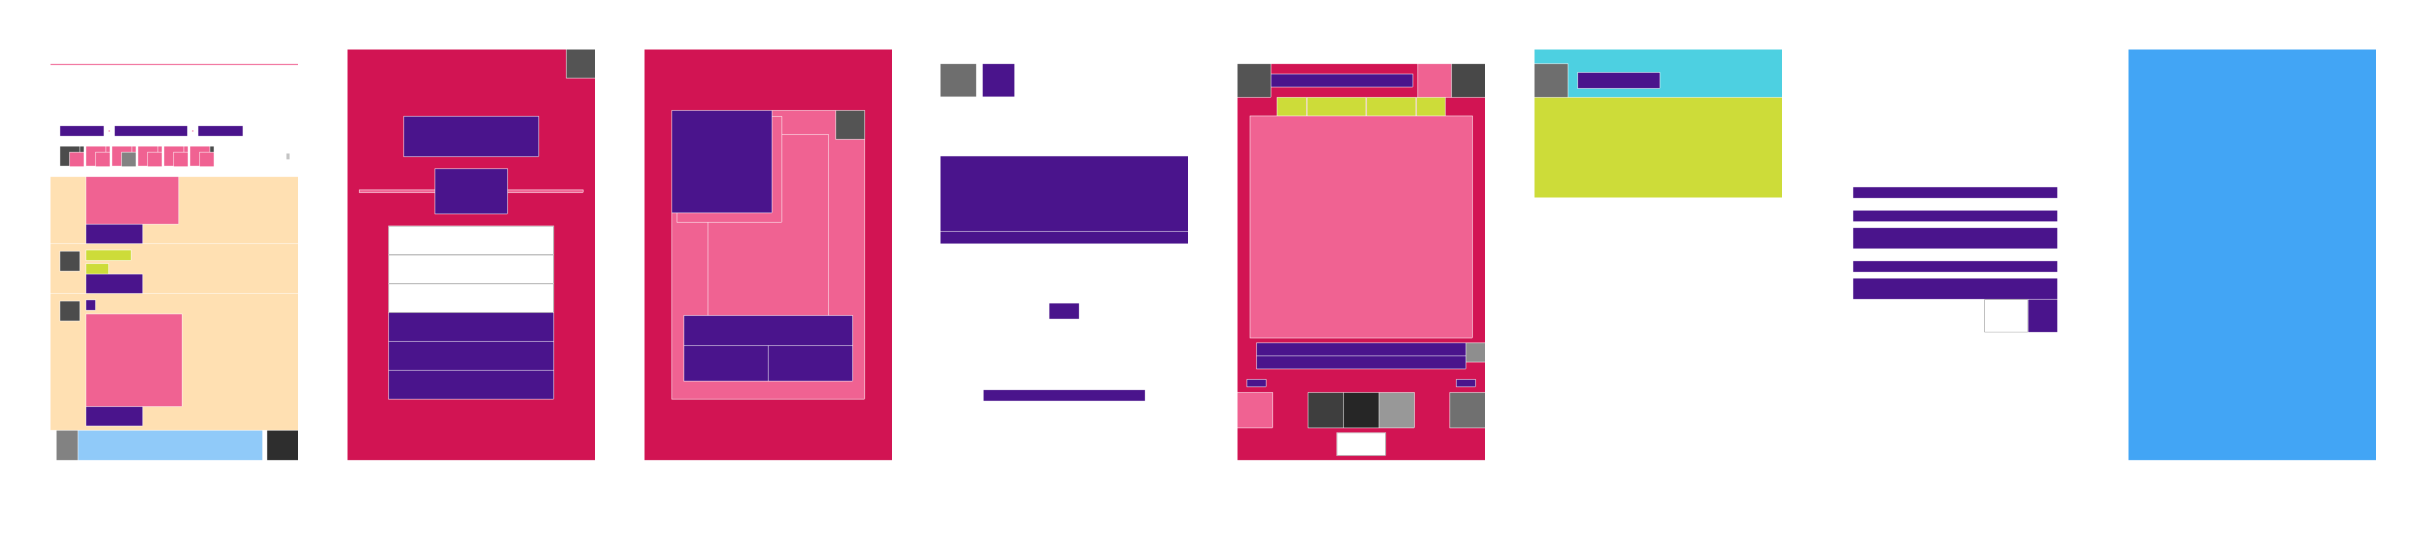

In [63]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

# figure size in inches optional

%matplotlib inline

clusters_labels = [0, 1, 2]
for i in clusters_labels:
    # popular_finall_df["ui_id"].values
    clust_examples = get_random_popular_examples(save_labels, i, 8, popular_finall_df["ui_id"].values)
    #print(list(clust_examples))

    # display images
    fig, ax = plt.subplots(1,8)
    fig.set_dpi(500)
    lista=[]
    
    # testing and making sure the results are correct
    #for j in range(len(clust_examples)):
    #    saved_popular_tensors = os.path.join(os.getcwd(), "popular_folder_972")
    #    
    #    iembed = torch.load(os.path.join(saved_popular_tensors, f"{clust_examples[j]}.pt"))
    #    #gets numpy embeddings from the embeddings
    #    numpy_embeddings = ((iembed.detach()).numpy()).reshape(1,-1)
    #    reduced_emb = reducer.transform(numpy_embeddings)
    #    lista.append(kmeans.predict(reduced_emb)[0])
    
    
    print(lista)
    
    for j in range(len(clust_examples)):
        filename = os.path.join(rico_layout_dataset, f"{clust_examples[j]}.png")
        img = mpimg.imread(filename)
        ax[j].imshow(img)
        ax[j].axis('off')

    fig.savefig(os.path.join(cluster_examples,f"example{i}.jpg"), dpi=fig.dpi)

**4.2.1 Regression Model**

In [59]:
#6, 7, 8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27

from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

y_pop = popular_finall_df['installs'].values
print(y_pop)

X_train, X_test, y_train, y_test = train_test_split(np_pop_embs, y_pop, test_size=.30, random_state=46,
                                                    stratify=y_pop)


reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
print("Accuracy on test set: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

[50000000 50000000 50000000 ... 50000000 50000000 50000000]
Accuracy on test set:  0.0
               precision    recall  f1-score   support

 -812825856.0       0.00      0.00      0.00       0.0
 -546113856.0       0.00      0.00      0.00       0.0
 -479125632.0       0.00      0.00      0.00       0.0
 -466322176.0       0.00      0.00      0.00       0.0
 -453509760.0       0.00      0.00      0.00       0.0
 -441122816.0       0.00      0.00      0.00       0.0
 -389655552.0       0.00      0.00      0.00       0.0
 -388142784.0       0.00      0.00      0.00       0.0
 -385194048.0       0.00      0.00      0.00       0.0
 -345151296.0       0.00      0.00      0.00       0.0
 -319985984.0       0.00      0.00      0.00       0.0
 -319023552.0       0.00      0.00      0.00       0.0
 -313033600.0       0.00      0.00      0.00       0.0
 -309768064.0       0.00      0.00      0.00       0.0
 -275898496.0       0.00      0.00      0.00       0.0
 -211973888.0       0.00      0.

C:\Users\rober_abgp8xd\anaconda3\envs\CAD_work\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rober_abgp8xd\anaconda3\envs\CAD_work\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rober_abgp8xd\anaconda3\envs\CAD_work\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

print(reg.coef_)

**4.2.2 Classification Model**

In [64]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
y_pop = list(popular_finall_df["category"].values)
y_final = []
for i in y_pop:
    y_final.append([i,])

print(y_final)
y_pop = enc.fit_transform(y_final).toarray()

print(y_pop)

X_train, X_test, y_train, y_test = train_test_split(np_pop_embs, y_pop, test_size=.30, random_state=46,
                                                    stratify=y_pop)


clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

y_pred = reg.predict(X_test)
print("Accuracy on test set: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

plot_tree(clf)

[['Weather'], ['Weather'], ['Weather'], ['Weather'], ['Weather'], ['Weather'], ['Music & Audio'], ['Music & Audio'], ['Music & Audio'], ['Music & Audio'], ['Music & Audio'], ['Music & Audio'], ['Music & Audio'], ['Music & Audio'], ['Music & Audio'], ['Music & Audio'], ['Music & Audio'], ['Music & Audio'], ['Shopping'], ['Shopping'], ['Shopping'], ['Shopping'], ['Shopping'], ['Shopping'], ['Shopping'], ['Shopping'], ['Shopping'], ['Shopping'], ['Shopping'], ['Shopping'], ['Shopping'], ['Shopping'], ['Shopping'], ['Shopping'], ['Food & Drink'], ['Food & Drink'], ['Lifestyle'], ['Lifestyle'], ['Lifestyle'], ['Lifestyle'], ['Lifestyle'], ['Lifestyle'], ['Lifestyle'], ['Lifestyle'], ['Lifestyle'], ['Lifestyle'], ['Shopping'], ['Shopping'], ['Shopping'], ['Shopping'], ['Shopping'], ['Entertainment'], ['Communication'], ['Communication'], ['Communication'], ['Communication'], ['Communication'], ['Travel & Local'], ['Travel & Local'], ['Travel & Local'], ['Travel & Local'], ['Travel & Local'],

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

## 5. RICO UI Layout Vectors

Compare the performance of clustering algorithms using RICO UI layout vectors.


In [43]:
lay_embs_unord = np.load(layout_embedding_csv)
lay_emb = np.zeros((len(found), 64), dtype=int)

f = open(ui_names_csv)
lay_index = json.load(f)["ui_names"]
j=0
for i in found:
    try:
        k = lay_index.index(str(i)+".png")
        i_emb = lay_embs_unord[k,:]
    except ValueError:
        i_emb = np.zeros((64,), dtype=int)
    lay_emb[j,:] = i_emb
    j+=1
    

f.close()

In [44]:
lay_emb.shape

(2022, 64)

**Applying PCA dimensionality reduction**

C:\Users\rober_abgp8xd\anaconda3\envs\CAD_work\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[2200.5879756627046, 1187.0363651639427, 767.1596429320088, 576.0148519663868, 473.75203848939503, 385.28291222270775, 327.3027533639653, 284.0825988760643, 255.615798931121, 224.89867804437534, 206.59465170432225, 189.84622292792665, 175.66627543743968, 163.9597253572387, 153.31882054200494, 145.07129365705566, 137.70002006609218, 127.8506588025053, 122.32502967681688, 117.7138279241711, 111.61386396088093, 105.77564996436705, 103.11660598287516, 97.61274988872216, 93.4954061010021, 88.3016277812155, 84.33259534168275, 81.83601261532586, 77.84770836375061]


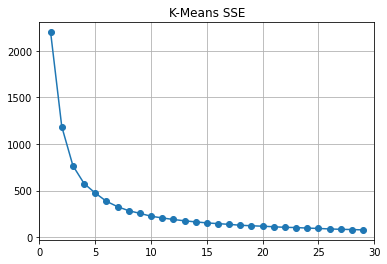

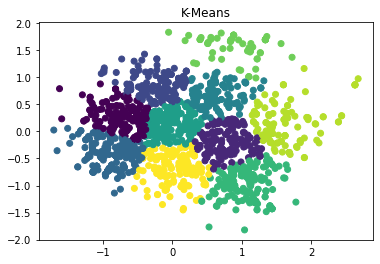

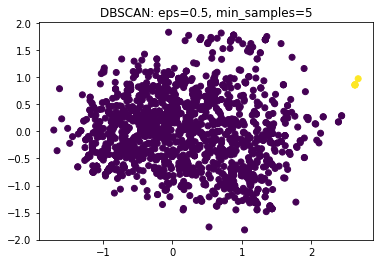

Estimated number of clusters: 2
Estimated number of noise points: 0


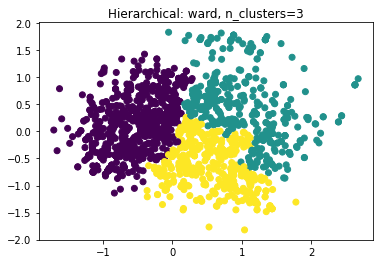

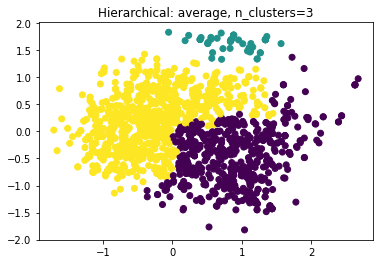

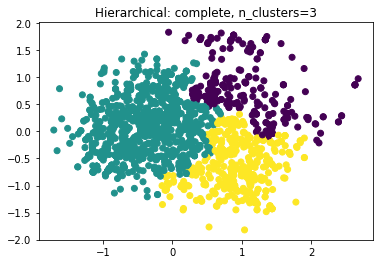

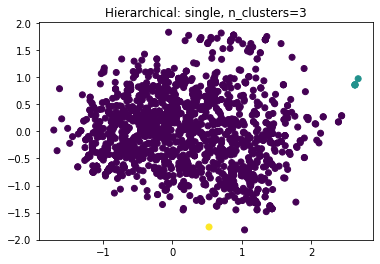

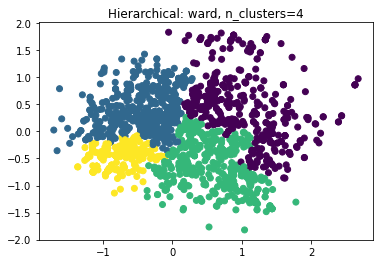

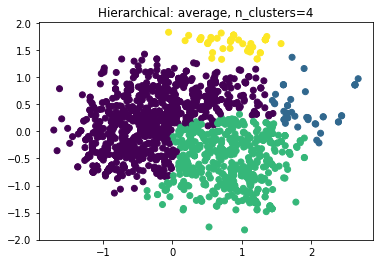

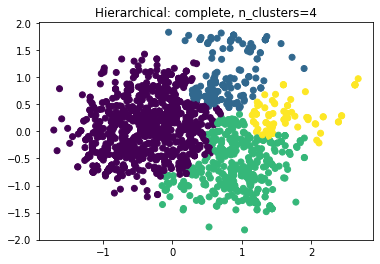

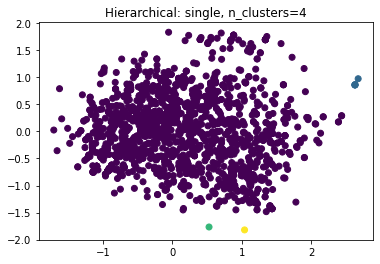

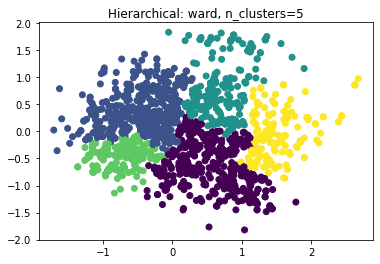

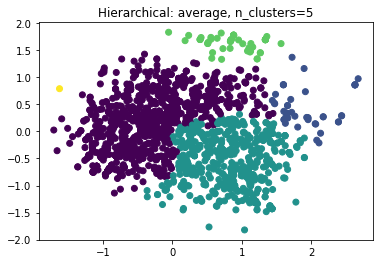

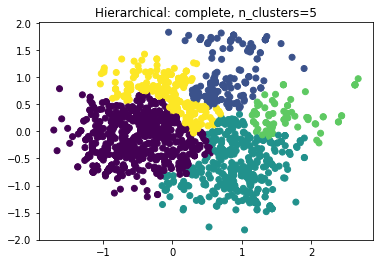

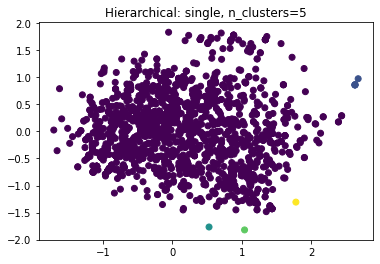

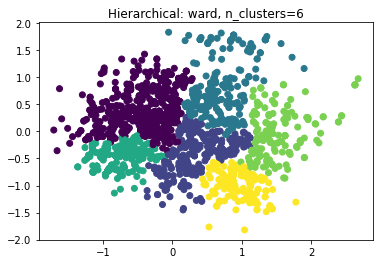

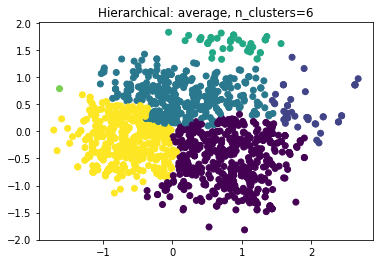

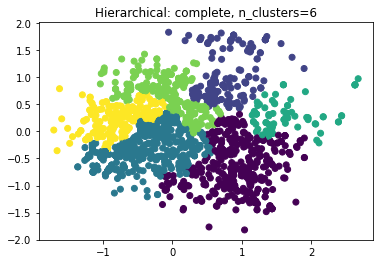

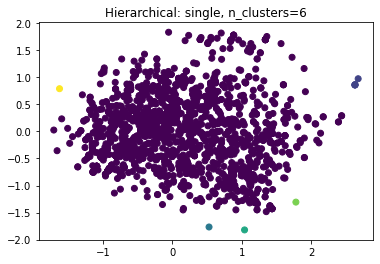

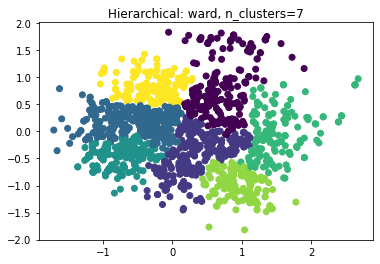

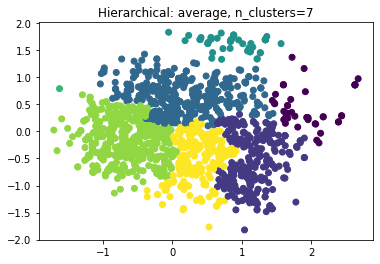

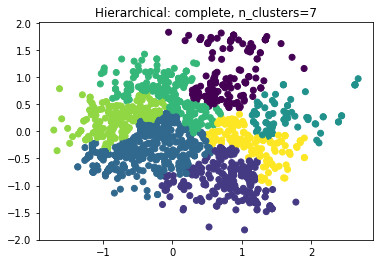

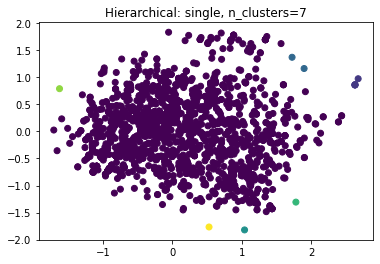

Finishing Program


In [45]:
# apply PCA to reduce the dimensionality of the embeddings
rico_emb = PCA(n_components = 2, random_state=2).fit_transform(lay_emb)

# compute SSE (sum squared error) vs number of clusters and find the "elbow point", the point after
# which the SSE or inertia starts decreasing in linear fashion
sse = compute_kmeans_sse(rico_emb, 30)

# apply k means
kmeans_n_clusters = 10
kmeans = KMeans(n_clusters = kmeans_n_clusters, n_init = 20, random_state = 10)
kmeans.fit(rico_emb)

plt.scatter(rico_emb[:,0], rico_emb[:,1], c=kmeans.labels_)
plt.title("K-Means")
#plt.savefig(os.path.join(saved_plt_path, "Kmeans"))
plt.show()

eps = 0.5
min_samples = 5

# DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(rico_emb)
plt.scatter(rico_emb[:,0], rico_emb[:,1], c=dbscan.labels_)
plt.title(f"DBSCAN: eps={eps}, min_samples={min_samples}")
#plt.savefig(os.path.join(saved_plt_path, "DBSCAN"))
plt.show()

dbscan_2 = DBSCAN(eps=eps, min_samples=min_samples).fit(rico_emb)
labels = dbscan_2.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)


#record_res.write("DBSCAN\n")
str_clusters = "Estimated number of clusters: %d" % n_clusters_
str_noise = "Estimated number of noise points: %d" % n_noise_

#record_res.write(str_clusters + "\n")
#record_res.write(str_noise + "\n")

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Agglomerative Clustering
# for clusters from 3 to 8, and the 4 linkage criteria
n_clusters = range(3,8)
linkage = ["ward", "average", "complete", "single"]


save_labels = []
for k in n_clusters:
    for criteria in linkage:
        clust = AgglomerativeClustering(n_clusters=k, linkage=criteria).fit(rico_emb)
        plt.scatter(rico_emb[:, 0], rico_emb[:, 1], c=clust.labels_)
        plt.title(f"Hierarchical: {criteria}, n_clusters={k}")
        #plt.savefig(os.path.join(saved_plt_path, f"AgglomerativeClustering~{k}~{criteria}"))
        plt.show()

print("Finishing Program")

**Apply UMAP dimensionality reduction**

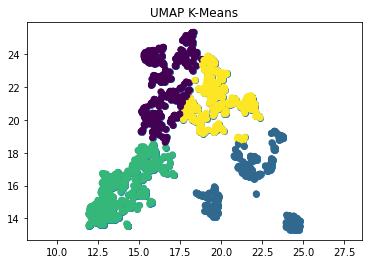

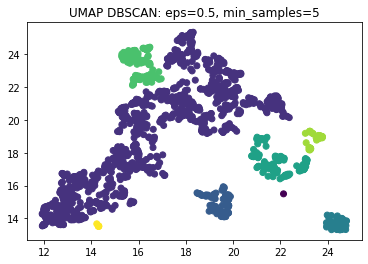

Estimated number of clusters: 7
Estimated number of noise points: 1


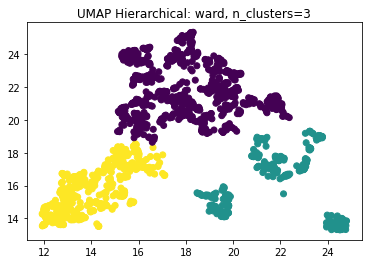

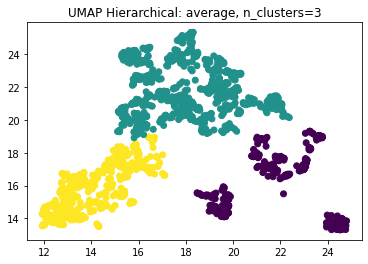

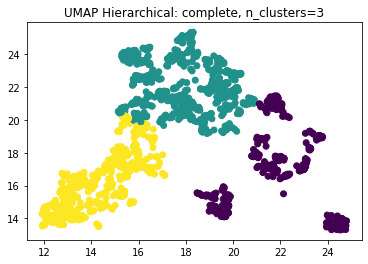

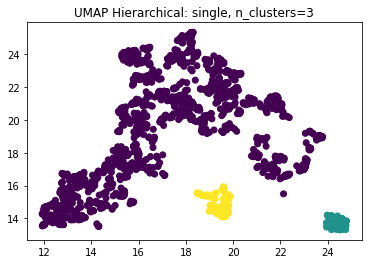

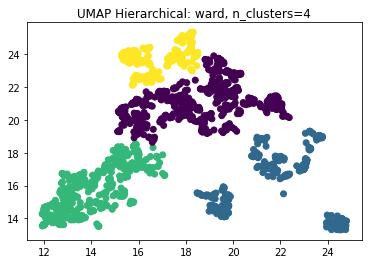

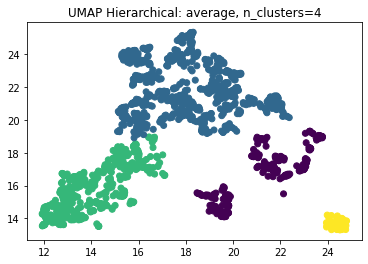

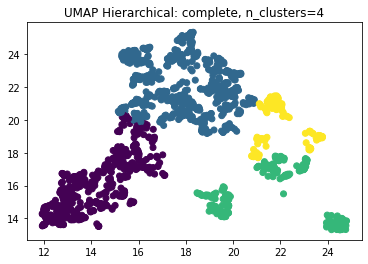

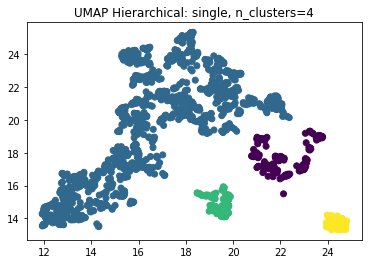

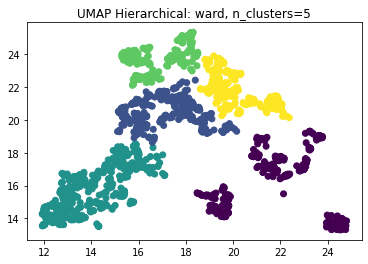

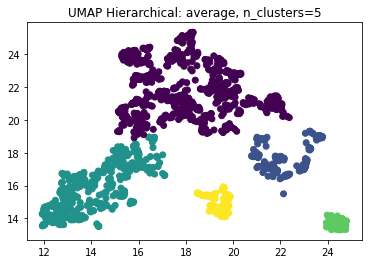

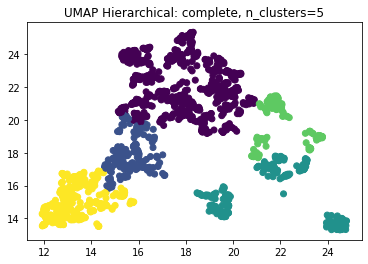

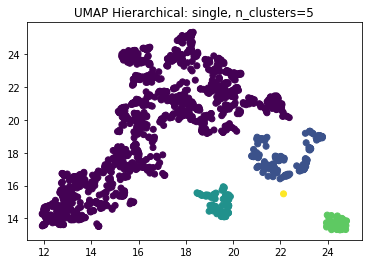

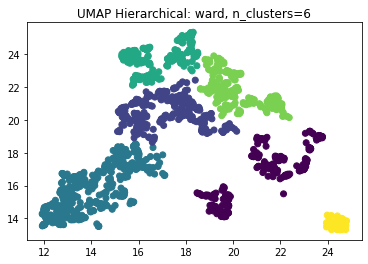

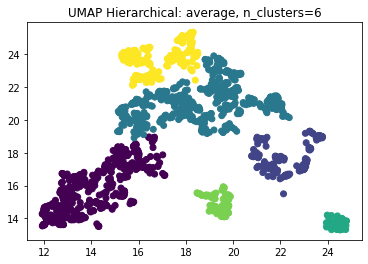

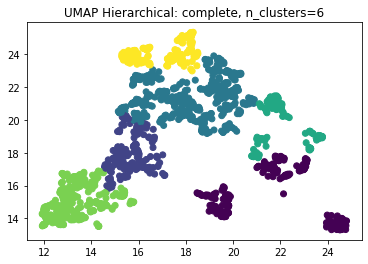

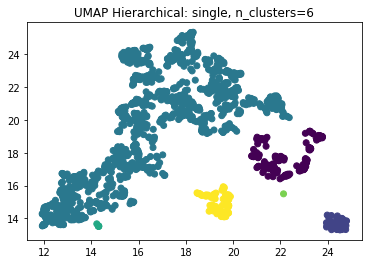

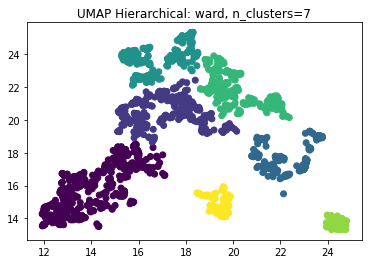

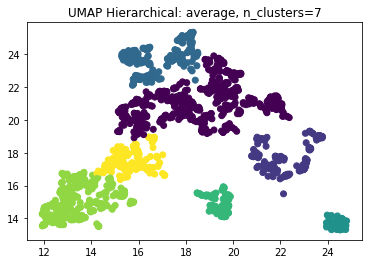

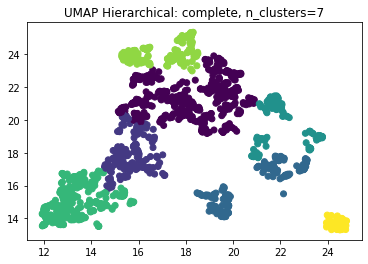

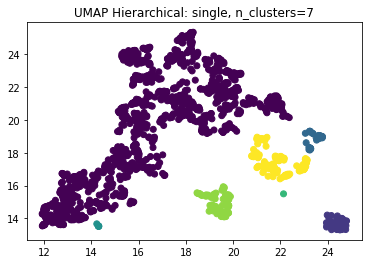

Finishing Program


In [46]:
import umap.umap_ as umap

reducer = umap.UMAP(random_state=4)
umap_embeddings = reducer.fit_transform(lay_emb)

plt.scatter(
    umap_embeddings[:, 0],
    umap_embeddings[:, 1],
    #c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
)
plt.gca().set_aspect('equal', 'datalim')
#plt.savefig(os.path.join(saved_plt_path, "UMAP_reduction"))
plt.title('UMAP Dimension reduction algorithm', fontsize=24)

# apply k means
kmeans_n_clusters = 4
kmeans = KMeans(n_clusters = kmeans_n_clusters, n_init = 20, random_state = 10)
kmeans.fit(umap_embeddings)

plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1], c=kmeans.labels_)
plt.title("UMAP K-Means")
#plt.savefig(os.path.join(saved_plt_path, "UMAP Kmeans"))
plt.show()

eps = 0.5
min_samples = 5

# DBSCAN
umap_dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(umap_embeddings)
plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1], c=umap_dbscan.labels_)
plt.title(f"UMAP DBSCAN: eps={eps}, min_samples={min_samples}")
#plt.savefig(os.path.join(saved_plt_path, "umap_DBSCAN"))
plt.show()

umap_dbscan_2 = DBSCAN(eps=eps, min_samples=min_samples).fit(umap_embeddings)
umap_labels = umap_dbscan_2.labels_
n_clusters_ = len(set(umap_labels)) - (1 if -1 in umap_labels else 0)
n_noise_ = list(umap_labels).count(-1)


#record_res.write("DBSCAN\n")
str_clusters = "Estimated number of clusters: %d" % n_clusters_
str_noise = "Estimated number of noise points: %d" % n_noise_

#record_res.write(str_clusters + "\n")
#record_res.write(str_noise + "\n")

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Agglomerative Clustering
# for clusters from 3 to 8, and the 4 linkage criteria
n_clusters = range(3,8)
linkage = ["ward", "average", "complete", "single"]


save_labels = []
for k in n_clusters:
    for criteria in linkage:
        clust = AgglomerativeClustering(n_clusters=k, linkage=criteria).fit(umap_embeddings)
        plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=clust.labels_)
        plt.title(f"UMAP Hierarchical: {criteria}, n_clusters={k}")
        #plt.savefig(os.path.join(saved_plt_path, f"UMAP AgglomerativeClustering~{k}~{criteria}"))
        plt.show()

print("Finishing Program")